In [11]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix


import matplotlib.colors as colors
import kerastuner as kt


from scipy.stats import probplot
from scipy.stats import normaltest


from joblib import dump, load

from ML_Train.Vanilla_AE import create_vanilla_ae
from ML_Train.Variational_AE import create_autoencoder as create_conv_vae
from ML_Train.Convolutional_AE import create_autoencoder as create_conv_ae
from ML_Train.Variational_Vanilla_AE import create_autoencoder as create_vanilla_vae
from ML_Train.CNN_Classifier import create_autoencoder as create_hybrid_cnn_ae
from ML_Train.CNN_Classifier import  build_classifier_from_vae, create_vae, create_classifier
# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

In [2]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [3]:
train_featuresDF = pd.read_csv('data/featuresDF_train.csv')
train_stats = pd.read_csv('data/stats_train.csv')
train_vibState = pd.read_csv('data/vibState_train.csv')

valid_featuresDF = pd.read_csv('data/featuresDF_valid.csv')
valid_stats = pd.read_csv('data/stats_valid.csv')
valid_vibState = pd.read_csv('data/vibState_valid.csv')


In [4]:
enc = OrdinalEncoder()
X_train = train_featuresDF.values[:,1:1025].astype(np.float32)
Y_train = enc.fit_transform(train_vibState.values[:,1][...,np.newaxis])

X_valid = valid_featuresDF.values[:,1:1025].astype(np.float32)
Y_valid = enc.transform(valid_vibState.values[:,1][...,np.newaxis])

X_train_healthy = X_train[np.argwhere(Y_train.flatten()==0).flatten(),:]
Y_train_healthy = Y_train[np.argwhere(Y_train.flatten()==0).flatten()]
X_train_unhealthy = X_train[np.argwhere(Y_train.flatten()==1).flatten(),:]
Y_train_unhealthy = Y_train[np.argwhere(Y_train.flatten()==1).flatten()]

X_valid_healthy = X_valid[np.argwhere(Y_valid.flatten()==0).flatten(),:]
Y_valid_healthy = Y_valid[np.argwhere(Y_valid.flatten()==0).flatten()]
X_valid_unhealthy = X_valid[np.argwhere(Y_valid.flatten()==1).flatten(),:]
Y_valid_unhealthy = Y_valid[np.argwhere(Y_valid.flatten()==1).flatten()]

XY_train_healthy = np.hstack((X_train_healthy,Y_train_healthy))
XY_valid_healthy = np.hstack((X_valid_healthy,Y_valid_healthy))
XY_train_unhealthy = np.hstack((X_train_unhealthy,Y_train_unhealthy))
XY_valid_unhealthy = np.hstack((X_valid_unhealthy,Y_valid_unhealthy))

XY_train = np.vstack((XY_train_healthy,XY_train_unhealthy))
XY_valid = np.vstack((XY_valid_healthy,XY_valid_unhealthy))

np.random.shuffle(XY_train)
np.random.shuffle(XY_valid)

X_train = XY_train[:,:-1]
Y_train = XY_train[:,-1]

X_valid = XY_valid[:,:-1]
Y_valid = XY_valid[:,-1]

num_samples = np.array([X_train.shape[0],
          X_valid.shape[0]])

max_samples = np.amax(num_samples)

In [5]:
def plot_confusion_matrix(y_true,y_pred,
                          labels,
                          filename='confusion_matrix'):
    
    predict_label = labels
    true_label = labels.copy()
    
    
    predict_label.insert(0, '')

    conf_matrix = np.round(confusion_matrix(y_true, y_pred) / y_pred.shape[0],2)
    
    true_positive = conf_matrix[0,0]
    true_negative = conf_matrix[1,1]
    false_positive = conf_matrix[0,1]
    false_negative = conf_matrix[1,0]
    
    true_positive_rate = true_positive / (true_positive + false_negative)
    true_negative_rate = true_negative / (true_negative + false_positive)
    
    balanced_accuracy = (true_positive_rate + true_negative_rate) / 2

    fig = plt.figure()
    ax = plt.gca()
    im = ax.matshow(conf_matrix,cmap='gray',norm=colors.Normalize(vmin=0.,vmax=.5))

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(true_label)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(true_label)
    ax.set_yticklabels(predict_label)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    xlabel = 'Actual State'
    ylabel = 'Predicted State'
    xlabelpad = 5

    plt.xlabel(r'\textbf{' + xlabel + '}', labelpad=xlabelpad)
    plt.ylabel(r'\textbf{' + ylabel + '}', labelpad=5)

    # Loop over data dimensions and create text annotations.
    for i in range(len(predict_label)-1):
        for j in range(len(true_label)):
            text_color = 'w'
            if conf_matrix[i,j] > 0.25:
                text_color = 'k'
            text = ax.text(j, i, r'\textbf{' + str(conf_matrix[i, j]) + '}',fontsize=22,
                           ha="center", va="center", color=text_color)

    cbar = plt.colorbar(im)
    cbar.set_label(r'\textbf{Occurrence Fraction}', rotation=270,labelpad=20)
    plt.tight_layout()
    plt.savefig('figures/' + filename + '.png',transparent=True)  
    plt.show()
    
    return balanced_accuracy, true_positive_rate, true_negative_rate

In [6]:
estimators = [('reduce_dim', PCA(n_components=32)), ('gnb', GaussianNB())]
# estimators = [('reduce_dim', KernelPCA(n_components=32,kernel='rbf')), ('gmm', GaussianMixture())]

pipe = Pipeline(estimators)
pipe.fit(X_train,Y_train)

Y_valid_pred = pipe.predict(X_valid)
conf_matrix_valid = confusion_matrix(Y_valid, Y_valid_pred)
accuracy_valid = np.sum(np.diagonal(conf_matrix_valid)) / np.sum(conf_matrix_valid)
print(conf_matrix_valid)
print(accuracy_valid)

Y_train_pred = pipe.predict(X_train)
conf_matrix_train = confusion_matrix(Y_train, Y_train_pred)
accuracy_train = np.sum(np.diagonal(conf_matrix_train)) / np.sum(conf_matrix_train)
print(conf_matrix_train)
print(accuracy_train)

dump(pipe, 'data/pca_gnb.joblib') 

[[273 427]
 [ 67 633]]
0.6471428571428571
[[624  76]
 [ 16 684]]
0.9342857142857143


['data/pca_gnb.joblib']

No handles with labels found to put in legend.


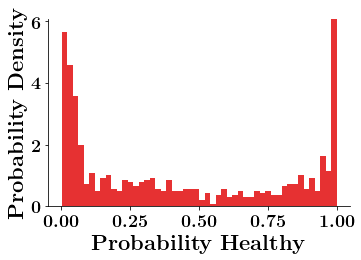

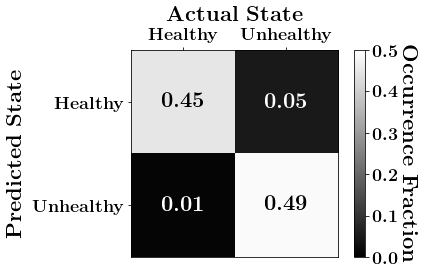

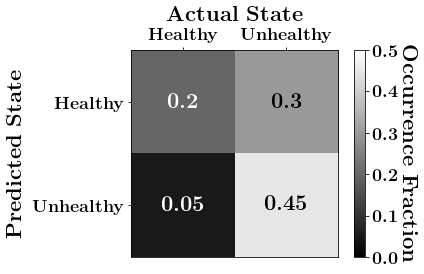

No handles with labels found to put in legend.


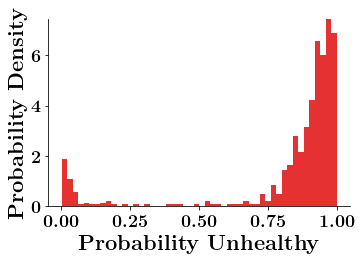

(0.9428341384863124, 0.9782608695652174, 0.9074074074074073)
(0.7, 0.8, 0.6)


In [7]:
pipe.predict_proba(X_train_healthy)[:,0]

responses= np.vstack((
                       pipe.predict_proba(X_valid_healthy)[:,0]))
genplt.plot_histogram(responses,[''],
               'Probability Healthy',
               'Probability Density',
               'pca_gnb_predict_healthy',
               template='publication',
               legend_loc='upper left',
               ymax=0.0,
               num_col=1,
               nbins=50)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'pca_gnb_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'pca_gnb_confmatrix_valid'
                       )

responses= np.vstack((
                       pipe.predict_proba(X_valid_unhealthy)[:,1]))
genplt.plot_histogram(responses,[''],
               'Probability Unhealthy',
               'Probability Density',
               'pca_gnb_predict_unhealthy',
               template='publication',
               legend_loc='upper left',
               ymax=0.0,
               num_col=1,
               nbins=50)

print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [8]:
def normalize_scores(scores,log_prob=False):
    
    if log_prob:
        scores = np.log(np.abs(scores - 1.1 * np.amax(scores)))
    
    norm_mean = np.mean(scores[:,0])
    norm_std = np.std(scores[:,0])
    
    scores = (scores - norm_mean) / norm_std
    
    [print(normaltest(scores[:,i])) for i in range(scores.shape[1])]
    [print(np.std(scores[:,i]), np.mean(scores[:,i])) for i in range(scores.shape[1])]
    
    return scores

In [15]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live, Sampling

def build_classifier(
                   hp
                   ):
    inputs = Input(shape=(1024,1))
    x = inputs
    
    for i in range(hp.Int('filters', 2, 5, step=1)):
        x = Conv1D(filters=hp.Int('filters_' + str(i), 4, 64, step=4), 
                           kernel_size=hp.Int('kernels_' + str(i), 3, 19, step=4), 
                           strides=1, 
                           activation='relu', 
                           padding='same',
                           dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Dropout(hp.Float('dropout_rate_' + str(i), 0.0, 0.5, step=0.1))(x)
        x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    
    for i in range(hp.Int('dense_layers', 1, 3, step=1)):
        x = Dense(hp.Int('dense_' + str(i), 8, 256, step=8), activation='relu')(x)

    x = Dense(2,activation='softmax')(x)
    
    cnn_classifier = Model(
                            inputs=[inputs],
                            outputs=[x])
    
    cnn_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
     
    
    return cnn_classifier
        

In [13]:
train = True
if not train:
# if os.path.isfile('../../Models/MLP-Classifier/Full/CNN-MLP.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('../../Models/MLP-Classifier/Full/CNN-MLP.h5')
    print(model.summary())
else:

    tuner = kt.Hyperband(
        build_classifier,
        objective='val_accuracy',
        max_epochs=30,
        hyperband_iterations=2,
        directory='cnn_fft_classifier',
        project_name='cnn_fft_classifier')

    tuner.search(X_train[...,np.newaxis],np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
                 validation_data=(X_valid[...,np.newaxis],np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
                 epochs=30,
                 callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])
    

    
#     print(model.summary())
    
#     model.save('../../Models/MLP-Classifier/Full/CNN-MLP.h5',save_format='tf')

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

open(os.path.join('../../Models/MLP-Classifier/Lite', 'CNN-MLP.tflite',),
     "wb").write(tflite_model)



Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 1:11 - loss: 0.7839 - accuracy: 0.59 - ETA: 6s - loss: 1.0862 - accuracy: 0.5347 - ETA: 2s - loss: 1.0758 - accuracy: 0.50 - ETA: 1s - loss: 1.0646 - accuracy: 0.51 - ETA: 0s - loss: 1.0488 - accuracy: 0.50 - ETA: 0s - loss: 1.0033 - accuracy: 0.51 - 2s 2ms/sample - loss: 0.9859 - accuracy: 0.5186 - val_loss: 0.7416 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.8672 - accuracy: 0.56 - ETA: 0s - loss: 0.8274 - accuracy: 0.55 - ETA: 0s - loss: 0.7935 - accuracy: 0.57 - ETA: 0s - loss: 0.7495 - accuracy: 0.59 - ETA: 0s - loss: 0.7384 - accuracy: 0.59 - ETA: 0s - loss: 0.7193 - accuracy: 0.60 - 0s 279us/sample - loss: 0.7153 - accuracy: 0.6064 - val_loss: 0.8319 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 24s - loss: 1.3662 - accuracy: 0.500 - ETA: 1s - loss: 0.7290 - accuracy: 0.682 - ETA: 0s - loss: 0.5164 - accuracy: 0.78 - ETA: 0s - loss: 0.4107 - accuracy: 0.83 - 1s 720us/sample - loss: 0.3465 - accuracy: 0.8643 - val_loss: 2.1542 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.93 - ETA: 0s - loss: 0.0600 - accuracy: 0.98 - ETA: 0s - loss: 0.0483 - accuracy: 0.98 - ETA: 0s - loss: 0.0644 - accuracy: 0.98 - 0s 207us/sample - loss: 0.0692 - accuracy: 0.9814 - val_loss: 4.7161 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 39s - loss: 1.3667 - accuracy: 0.500 - ETA: 3s - loss: 1.1780 - accuracy: 0.596 - ETA: 1s - loss: 0.9445 - accuracy: 0.64 - ETA: 0s - loss: 0.8511 - accuracy: 0.67 - ETA: 0s - loss: 0.7777 - accuracy: 0.69 - 2s 1ms/sample - loss: 0.7674 - accuracy: 0.7029 - val_loss: 0.8650 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.78 - ETA: 0s - loss: 0.3886 - accuracy: 0.82 - ETA: 0s - loss: 0.3885 - accuracy: 0.82 - ETA: 0s - loss: 0.3486 - accuracy: 0.84 - ETA: 0s - loss: 0.3199 - accuracy: 0.86 - 0s 236us/sample - loss: 0.3192 - accuracy: 0.8650 - val_loss: 1.2377 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 41s - loss: 1.1501 - accuracy: 0.593 - ETA: 3s - loss: 1.1479 - accuracy: 0.568 - ETA: 1s - loss: 0.8781 - accuracy: 0.63 - ETA: 0s - loss: 0.7306 - accuracy: 0.69 - ETA: 0s - loss: 0.6044 - accuracy: 0.74 - ETA: 0s - loss: 0.5147 - accuracy: 0.78 - 2s 1ms/sample - loss: 0.5073 - accuracy: 0.7879 - val_loss: 1.1232 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 1.00 - ETA: 0s - loss: 0.0705 - accuracy: 0.98 - ETA: 0s - loss: 0.0831 - accuracy: 0.97 - ETA: 0s - loss: 0.0965 - accuracy: 0.97 - ETA: 0s - loss: 0.0887 - accuracy: 0.97 - 0s 255us/sample - loss: 0.0855 - accuracy: 0.9714 - val_loss: 1.5352 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 17s - loss: 1.1132 - accuracy: 0.562 - ETA: 0s - loss: 0.7646 - accuracy: 0.726 - ETA: 0s - loss: 0.4623 - accuracy: 0.83 - 1s 557us/sample - loss: 0.3307 - accuracy: 0.8807 - val_loss: 0.6645 - val_accuracy: 0.7271
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0234 - accuracy: 1.00 - ETA: 0s - loss: 0.0072 - accuracy: 1.00 - ETA: 0s - loss: 0.0055 - accuracy: 0.99 - 0s 157us/sample - loss: 0.0050 - accuracy: 0.9993 - val_loss: 0.9488 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 24s - loss: 1.4032 - accuracy: 0.437 - ETA: 2s - loss: 4.0775 - accuracy: 0.521 - ETA: 0s - loss: 2.3700 - accuracy: 0.68 - ETA: 0s - loss: 1.6376 - accuracy: 0.77 - ETA: 0s - loss: 1.2606 - accuracy: 0.82 - 1s 785us/sample - loss: 1.0670 - accuracy: 0.8521 - val_loss: 2.2437 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 8.7834e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0030 - accuracy: 1.0000   - ETA: 0s - loss: 0.0042 - accuracy: 0.99 - ETA: 0s - loss: 0.0034 - accuracy: 0.99 - ETA: 0s - loss: 0.0028 - accuracy: 0.99 - 0s 267us/sample - loss: 0.0030 - accuracy: 0.9986 - val_loss: 4.7619 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 24s - loss: 1.0818 - accuracy: 0.625 - ETA: 2s - loss: 1.7357 - accuracy: 0.635 - ETA: 1s - loss: 1.2040 - accuracy: 0.69 - ETA: 0s - loss: 0.8665 - accuracy: 0.77 - ETA: 0s - loss: 0.6881 - accuracy: 0.82 - ETA: 0s - loss: 0.5724 - accuracy: 0.85 - 1s 827us/sample - loss: 0.5027 - accuracy: 0.8700 - val_loss: 3.2598 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 1.00 - ETA: 0s - loss: 0.0183 - accuracy: 1.00 - ETA: 0s - loss: 0.0199 - accuracy: 0.99 - ETA: 0s - loss: 0.0189 - accuracy: 0.99 - ETA: 0s - loss: 0.0187 - accuracy: 0.99 - ETA: 0s - loss: 0.0176 - accuracy: 0.99 - 0s 311us/sample - loss: 0.0167 - accuracy: 0.9986 - val_loss: 4.8443 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 32s - loss: 1.6209 - accuracy: 0.562 - ETA: 2s - loss: 8.2614 - accuracy: 0.537 - ETA: 1s - loss: 4.9976 - accuracy: 0.52 - ETA: 0s - loss: 3.5704 - accuracy: 0.56 - ETA: 0s - loss: 2.7544 - accuracy: 0.63 - 1s 957us/sample - loss: 2.2940 - accuracy: 0.6929 - val_loss: 3.4347 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.96 - ETA: 0s - loss: 0.0711 - accuracy: 0.97 - ETA: 0s - loss: 0.0584 - accuracy: 0.97 - ETA: 0s - loss: 0.0511 - accuracy: 0.98 - ETA: 0s - loss: 0.0442 - accuracy: 0.98 - ETA: 0s - loss: 0.0380 - accuracy: 0.98 - 0s 287us/sample - loss: 0.0366 - accuracy: 0.9850 - val_loss: 1.3622 - val_accuracy: 0.5286


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 17s - loss: 1.6216 - accuracy: 0.500 - ETA: 1s - loss: 2.1629 - accuracy: 0.706 - ETA: 0s - loss: 1.2829 - accuracy: 0.79 - ETA: 0s - loss: 0.8938 - accuracy: 0.85 - ETA: 0s - loss: 0.6820 - accuracy: 0.88 - 1s 629us/sample - loss: 0.5825 - accuracy: 0.9021 - val_loss: 2.2579 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 1.00 - ETA: 0s - loss: 0.0063 - accuracy: 1.00 - ETA: 0s - loss: 0.0063 - accuracy: 1.00 - ETA: 0s - loss: 0.0069 - accuracy: 0.99 - ETA: 0s - loss: 0.0080 - accuracy: 0.99 - 0s 259us/sample - loss: 0.0086 - accuracy: 0.9971 - val_loss: 5.4187 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 22s - loss: 1.2640 - accuracy: 0.437 - ETA: 1s - loss: 0.8884 - accuracy: 0.644 - ETA: 0s - loss: 0.7252 - accuracy: 0.69 - ETA: 0s - loss: 0.5972 - accuracy: 0.75 - 1s 680us/sample - loss: 0.5275 - accuracy: 0.7807 - val_loss: 0.8934 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.96 - ETA: 0s - loss: 0.1439 - accuracy: 0.94 - ETA: 0s - loss: 0.1437 - accuracy: 0.94 - ETA: 0s - loss: 0.1274 - accuracy: 0.95 - 0s 214us/sample - loss: 0.1189 - accuracy: 0.9579 - val_loss: 1.5013 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 18s - loss: 1.0155 - accuracy: 0.531 - ETA: 1s - loss: 1.0151 - accuracy: 0.677 - ETA: 0s - loss: 0.7234 - accuracy: 0.76 - ETA: 0s - loss: 0.5135 - accuracy: 0.83 - ETA: 0s - loss: 0.4146 - accuracy: 0.86 - ETA: 0s - loss: 0.3457 - accuracy: 0.88 - 1s 683us/sample - loss: 0.3262 - accuracy: 0.8921 - val_loss: 0.8060 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 1.00 - ETA: 0s - loss: 0.0151 - accuracy: 1.00 - ETA: 0s - loss: 0.0180 - accuracy: 0.99 - ETA: 0s - loss: 0.0142 - accuracy: 0.99 - ETA: 0s - loss: 0.0123 - accuracy: 0.99 - ETA: 0s - loss: 0.0119 - accuracy: 0.99 - 0s 282us/sample - loss: 0.0133 - accuracy: 0.9979 - val_loss: 1.4462 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 22s - loss: 1.8205 - accuracy: 0.500 - ETA: 2s - loss: 2.0945 - accuracy: 0.604 - ETA: 0s - loss: 1.4082 - accuracy: 0.71 - ETA: 0s - loss: 1.0684 - accuracy: 0.77 - ETA: 0s - loss: 0.8330 - accuracy: 0.81 - ETA: 0s - loss: 0.6873 - accuracy: 0.84 - 1s 752us/sample - loss: 0.6454 - accuracy: 0.8571 - val_loss: 1.6273 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 1.00 - ETA: 0s - loss: 0.0206 - accuracy: 0.99 - ETA: 0s - loss: 0.0156 - accuracy: 0.99 - ETA: 0s - loss: 0.0121 - accuracy: 0.99 - ETA: 0s - loss: 0.0112 - accuracy: 0.99 - ETA: 0s - loss: 0.0097 - accuracy: 0.99 - 0s 282us/sample - loss: 0.0098 - accuracy: 0.9986 - val_loss: 1.6453 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 38s - loss: 1.7320 - accuracy: 0.500 - ETA: 3s - loss: 1.3160 - accuracy: 0.541 - ETA: 1s - loss: 1.1749 - accuracy: 0.56 - ETA: 0s - loss: 1.1183 - accuracy: 0.57 - ETA: 0s - loss: 1.1099 - accuracy: 0.59 - ETA: 0s - loss: 1.0784 - accuracy: 0.60 - 2s 1ms/sample - loss: 1.0587 - accuracy: 0.6043 - val_loss: 0.7324 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.9319 - accuracy: 0.65 - ETA: 0s - loss: 0.8487 - accuracy: 0.68 - ETA: 0s - loss: 0.8664 - accuracy: 0.66 - ETA: 0s - loss: 0.8649 - accuracy: 0.66 - ETA: 0s - loss: 0.8381 - accuracy: 0.66 - ETA: 0s - loss: 0.8144 - accuracy: 0.67 - 0s 292us/sample - loss: 0.8046 - accuracy: 0.6779 - val_loss: 1.2771 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 31s - loss: 0.8456 - accuracy: 0.781 - ETA: 2s - loss: 1.7507 - accuracy: 0.581 - ETA: 1s - loss: 1.2273 - accuracy: 0.57 - ETA: 0s - loss: 0.9886 - accuracy: 0.63 - ETA: 0s - loss: 0.8313 - accuracy: 0.68 - 1s 941us/sample - loss: 0.7237 - accuracy: 0.7286 - val_loss: 1.7238 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 1.00 - ETA: 0s - loss: 0.0546 - accuracy: 0.98 - ETA: 0s - loss: 0.0485 - accuracy: 0.98 - ETA: 0s - loss: 0.0418 - accuracy: 0.98 - ETA: 0s - loss: 0.0352 - accuracy: 0.98 - 0s 251us/sample - loss: 0.0315 - accuracy: 0.9900 - val_loss: 5.5420 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 18s - loss: 1.0758 - accuracy: 0.500 - ETA: 0s - loss: 1.1412 - accuracy: 0.720 - ETA: 0s - loss: 0.6299 - accuracy: 0.83 - 1s 556us/sample - loss: 0.4298 - accuracy: 0.8907 - val_loss: 0.7537 - val_accuracy: 0.4993
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.00 - ETA: 0s - loss: 0.0178 - accuracy: 0.99 - ETA: 0s - loss: 0.0123 - accuracy: 0.99 - ETA: 0s - loss: 0.0091 - accuracy: 0.99 - 0s 193us/sample - loss: 0.0088 - accuracy: 0.9971 - val_loss: 1.1296 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 39s - loss: 1.9513 - accuracy: 0.468 - ETA: 4s - loss: 1.2021 - accuracy: 0.546 - ETA: 2s - loss: 1.0610 - accuracy: 0.56 - ETA: 1s - loss: 1.0058 - accuracy: 0.56 - ETA: 0s - loss: 0.9388 - accuracy: 0.58 - ETA: 0s - loss: 0.8922 - accuracy: 0.61 - 2s 1ms/sample - loss: 0.8660 - accuracy: 0.6214 - val_loss: 1.6463 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.6971 - accuracy: 0.71 - ETA: 0s - loss: 0.5854 - accuracy: 0.72 - ETA: 0s - loss: 0.5595 - accuracy: 0.73 - ETA: 0s - loss: 0.5398 - accuracy: 0.74 - ETA: 0s - loss: 0.5256 - accuracy: 0.75 - ETA: 0s - loss: 0.5079 - accuracy: 0.76 - 0s 311us/sample - loss: 0.4921 - accuracy: 0.7750 - val_loss: 2.8286 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 23s - loss: 1.2438 - accuracy: 0.437 - ETA: 1s - loss: 3.0115 - accuracy: 0.541 - ETA: 0s - loss: 1.8387 - accuracy: 0.68 - ETA: 0s - loss: 1.2747 - accuracy: 0.77 - ETA: 0s - loss: 1.0048 - accuracy: 0.81 - 1s 717us/sample - loss: 0.9876 - accuracy: 0.8193 - val_loss: 1.9425 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 1.00 - ETA: 0s - loss: 0.0381 - accuracy: 0.99 - ETA: 0s - loss: 0.0269 - accuracy: 0.99 - ETA: 0s - loss: 0.0260 - accuracy: 0.99 - 0s 218us/sample - loss: 0.0295 - accuracy: 0.9943 - val_loss: 0.6730 - val_accuracy: 0.4814


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 23s - loss: 1.2336 - accuracy: 0.562 - ETA: 1s - loss: 1.4504 - accuracy: 0.690 - ETA: 0s - loss: 0.9707 - accuracy: 0.74 - ETA: 0s - loss: 0.6786 - accuracy: 0.81 - 1s 699us/sample - loss: 0.5384 - accuracy: 0.8529 - val_loss: 3.6905 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 1.00 - ETA: 0s - loss: 0.0415 - accuracy: 0.98 - ETA: 0s - loss: 0.0315 - accuracy: 0.98 - ETA: 0s - loss: 0.0238 - accuracy: 0.99 - 0s 205us/sample - loss: 0.0225 - accuracy: 0.9929 - val_loss: 5.2685 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 33s - loss: 1.1272 - accuracy: 0.687 - ETA: 2s - loss: 1.3695 - accuracy: 0.521 - ETA: 1s - loss: 1.1867 - accuracy: 0.55 - ETA: 0s - loss: 1.0490 - accuracy: 0.57 - ETA: 0s - loss: 0.9492 - accuracy: 0.59 - 1s 1ms/sample - loss: 0.8775 - accuracy: 0.6200 - val_loss: 0.8938 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.5164 - accuracy: 0.68 - ETA: 0s - loss: 0.4822 - accuracy: 0.72 - ETA: 0s - loss: 0.4630 - accuracy: 0.75 - ETA: 0s - loss: 0.4410 - accuracy: 0.77 - ETA: 0s - loss: 0.4207 - accuracy: 0.79 - 0s 253us/sample - loss: 0.3990 - accuracy: 0.8036 - val_loss: 1.3969 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 17s - loss: 1.3334 - accuracy: 0.468 - ETA: 1s - loss: 1.2054 - accuracy: 0.679 - ETA: 0s - loss: 0.9167 - accuracy: 0.75 - ETA: 0s - loss: 0.7031 - accuracy: 0.80 - ETA: 0s - loss: 0.5550 - accuracy: 0.84 - 1s 619us/sample - loss: 0.5084 - accuracy: 0.8579 - val_loss: 1.1302 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 1.00 - ETA: 0s - loss: 0.0725 - accuracy: 0.97 - ETA: 0s - loss: 0.0538 - accuracy: 0.98 - ETA: 0s - loss: 0.0473 - accuracy: 0.98 - ETA: 0s - loss: 0.0375 - accuracy: 0.98 - 0s 243us/sample - loss: 0.0378 - accuracy: 0.9871 - val_loss: 2.0332 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 34s - loss: 1.3883 - accuracy: 0.562 - ETA: 3s - loss: 0.9673 - accuracy: 0.569 - ETA: 1s - loss: 0.8460 - accuracy: 0.59 - ETA: 0s - loss: 0.7542 - accuracy: 0.64 - ETA: 0s - loss: 0.6941 - accuracy: 0.66 - 1s 1ms/sample - loss: 0.6544 - accuracy: 0.6814 - val_loss: 0.6903 - val_accuracy: 0.6000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.4257 - accuracy: 0.75 - ETA: 0s - loss: 0.4064 - accuracy: 0.79 - ETA: 0s - loss: 0.3694 - accuracy: 0.82 - ETA: 0s - loss: 0.3572 - accuracy: 0.83 - ETA: 0s - loss: 0.3420 - accuracy: 0.84 - ETA: 0s - loss: 0.3172 - accuracy: 0.85 - 0s 272us/sample - loss: 0.3174 - accuracy: 0.8579 - val_loss: 0.6934 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 18s - loss: 1.4613 - accuracy: 0.468 - ETA: 1s - loss: 3.5312 - accuracy: 0.579 - ETA: 0s - loss: 2.0400 - accuracy: 0.71 - ETA: 0s - loss: 1.3987 - accuracy: 0.80 - ETA: 0s - loss: 1.0761 - accuracy: 0.84 - ETA: 0s - loss: 0.8679 - accuracy: 0.87 - 1s 682us/sample - loss: 0.8158 - accuracy: 0.8814 - val_loss: 0.8979 - val_accuracy: 0.4400
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.96 - ETA: 0s - loss: 0.0562 - accuracy: 0.98 - ETA: 0s - loss: 0.0307 - accuracy: 0.99 - ETA: 0s - loss: 0.0233 - accuracy: 0.99 - ETA: 0s - loss: 0.0182 - accuracy: 0.99 - 0s 297us/sample - loss: 0.0152 - accuracy: 0.9971 - val_loss: 0.9443 - val_accuracy: 0.4886


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 34s - loss: 2.4213 - accuracy: 0.500 - ETA: 2s - loss: 3.5834 - accuracy: 0.610 - ETA: 1s - loss: 2.1584 - accuracy: 0.64 - ETA: 0s - loss: 1.5221 - accuracy: 0.72 - ETA: 0s - loss: 1.1977 - accuracy: 0.77 - 1s 1ms/sample - loss: 1.1558 - accuracy: 0.7829 - val_loss: 6.3984 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0498 - accuracy: 0.96 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.0833 - accuracy: 0.96 - ETA: 0s - loss: 0.0681 - accuracy: 0.97 - ETA: 0s - loss: 0.0604 - accuracy: 0.97 - 0s 227us/sample - loss: 0.0595 - accuracy: 0.9779 - val_loss: 11.5348 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 37s - loss: 1.3085 - accuracy: 0.562 - ETA: 3s - loss: 1.1662 - accuracy: 0.555 - ETA: 1s - loss: 0.9757 - accuracy: 0.61 - ETA: 0s - loss: 0.8472 - accuracy: 0.65 - ETA: 0s - loss: 0.7573 - accuracy: 0.68 - 2s 1ms/sample - loss: 0.6656 - accuracy: 0.7193 - val_loss: 1.1403 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.84 - ETA: 0s - loss: 0.2764 - accuracy: 0.88 - ETA: 0s - loss: 0.2470 - accuracy: 0.88 - ETA: 0s - loss: 0.2308 - accuracy: 0.90 - ETA: 0s - loss: 0.2093 - accuracy: 0.91 - 0s 257us/sample - loss: 0.2033 - accuracy: 0.9157 - val_loss: 2.7159 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 23s - loss: 1.8267 - accuracy: 0.531 - ETA: 1s - loss: 0.9917 - accuracy: 0.659 - ETA: 0s - loss: 0.6292 - accuracy: 0.76 - ETA: 0s - loss: 0.4908 - accuracy: 0.81 - ETA: 0s - loss: 0.3933 - accuracy: 0.85 - 1s 727us/sample - loss: 0.3873 - accuracy: 0.8564 - val_loss: 1.0007 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 1.00 - ETA: 0s - loss: 0.0494 - accuracy: 0.98 - ETA: 0s - loss: 0.0483 - accuracy: 0.98 - ETA: 0s - loss: 0.0418 - accuracy: 0.98 - 0s 217us/sample - loss: 0.0438 - accuracy: 0.9850 - val_loss: 1.1308 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 23s - loss: 1.2105 - accuracy: 0.406 - ETA: 1s - loss: 0.9708 - accuracy: 0.544 - ETA: 0s - loss: 0.8372 - accuracy: 0.59 - ETA: 0s - loss: 0.7324 - accuracy: 0.64 - ETA: 0s - loss: 0.6511 - accuracy: 0.68 - 1s 729us/sample - loss: 0.6491 - accuracy: 0.6907 - val_loss: 0.9538 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.90 - ETA: 0s - loss: 0.3309 - accuracy: 0.85 - ETA: 0s - loss: 0.3127 - accuracy: 0.85 - ETA: 0s - loss: 0.2823 - accuracy: 0.87 - 0s 222us/sample - loss: 0.2713 - accuracy: 0.8764 - val_loss: 1.8720 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 31s - loss: 1.4177 - accuracy: 0.562 - ETA: 3s - loss: 2.5193 - accuracy: 0.572 - ETA: 1s - loss: 1.8670 - accuracy: 0.64 - ETA: 0s - loss: 1.3480 - accuracy: 0.71 - ETA: 0s - loss: 1.0370 - accuracy: 0.77 - 1s 926us/sample - loss: 0.8638 - accuracy: 0.8136 - val_loss: 0.8343 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 1.00 - ETA: 0s - loss: 0.0360 - accuracy: 0.98 - ETA: 0s - loss: 0.0635 - accuracy: 0.97 - ETA: 0s - loss: 0.0500 - accuracy: 0.98 - ETA: 0s - loss: 0.0443 - accuracy: 0.98 - 0s 256us/sample - loss: 0.0409 - accuracy: 0.9850 - val_loss: 1.7140 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 24s - loss: 1.9068 - accuracy: 0.406 - ETA: 1s - loss: 2.2927 - accuracy: 0.700 - ETA: 0s - loss: 1.3055 - accuracy: 0.81 - ETA: 0s - loss: 0.9049 - accuracy: 0.86 - 1s 732us/sample - loss: 0.7264 - accuracy: 0.8879 - val_loss: 3.5194 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.00 - ETA: 0s - loss: 0.0048 - accuracy: 1.00 - ETA: 0s - loss: 0.0142 - accuracy: 0.99 - ETA: 0s - loss: 0.0249 - accuracy: 0.99 - 0s 226us/sample - loss: 0.0219 - accuracy: 0.9950 - val_loss: 1.1369 - val_accuracy: 0.5243


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 42s - loss: 1.6036 - accuracy: 0.500 - ETA: 4s - loss: 0.8817 - accuracy: 0.642 - ETA: 1s - loss: 0.7427 - accuracy: 0.67 - ETA: 0s - loss: 0.6204 - accuracy: 0.73 - ETA: 0s - loss: 0.5464 - accuracy: 0.77 - ETA: 0s - loss: 0.4872 - accuracy: 0.80 - 2s 1ms/sample - loss: 0.4598 - accuracy: 0.8129 - val_loss: 1.8010 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.2052 - accuracy: 0.90 - ETA: 0s - loss: 0.1559 - accuracy: 0.93 - ETA: 0s - loss: 0.1213 - accuracy: 0.95 - ETA: 0s - loss: 0.1104 - accuracy: 0.95 - ETA: 0s - loss: 0.0974 - accuracy: 0.96 - ETA: 0s - loss: 0.0900 - accuracy: 0.96 - 0s 290us/sample - loss: 0.0880 - accuracy: 0.9671 - val_loss: 2.4386 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 18s - loss: 1.9299 - accuracy: 0.500 - ETA: 1s - loss: 2.3828 - accuracy: 0.658 - ETA: 0s - loss: 1.3385 - accuracy: 0.78 - ETA: 0s - loss: 0.9404 - accuracy: 0.84 - 1s 584us/sample - loss: 0.8675 - accuracy: 0.8500 - val_loss: 2.4584 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.00 - ETA: 0s - loss: 0.0233 - accuracy: 0.99 - ETA: 0s - loss: 0.0203 - accuracy: 0.99 - ETA: 0s - loss: 0.0170 - accuracy: 0.99 - 0s 182us/sample - loss: 0.0161 - accuracy: 0.9943 - val_loss: 3.5270 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 24s - loss: 1.2519 - accuracy: 0.375 - ETA: 1s - loss: 1.0951 - accuracy: 0.619 - ETA: 0s - loss: 0.7275 - accuracy: 0.74 - ETA: 0s - loss: 0.5137 - accuracy: 0.81 - 1s 715us/sample - loss: 0.4227 - accuracy: 0.8521 - val_loss: 0.7126 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 1.00 - ETA: 0s - loss: 0.1443 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.97 - ETA: 0s - loss: 0.0771 - accuracy: 0.97 - 0s 216us/sample - loss: 0.0657 - accuracy: 0.9814 - val_loss: 1.6502 - val_accuracy: 0.5279


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 38s - loss: 0.8059 - accuracy: 0.625 - ETA: 3s - loss: 1.0087 - accuracy: 0.568 - ETA: 1s - loss: 0.8462 - accuracy: 0.62 - ETA: 0s - loss: 0.8173 - accuracy: 0.65 - ETA: 0s - loss: 0.7129 - accuracy: 0.69 - ETA: 0s - loss: 0.6339 - accuracy: 0.73 - 2s 1ms/sample - loss: 0.6252 - accuracy: 0.7386 - val_loss: 2.6616 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.1667 - accuracy: 0.93 - ETA: 0s - loss: 0.2435 - accuracy: 0.88 - ETA: 0s - loss: 0.2087 - accuracy: 0.90 - ETA: 0s - loss: 0.2043 - accuracy: 0.90 - ETA: 0s - loss: 0.1994 - accuracy: 0.91 - 0s 269us/sample - loss: 0.1884 - accuracy: 0.9214 - val_loss: 4.8070 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 31s - loss: 1.9531 - accuracy: 0.312 - ETA: 3s - loss: 1.7697 - accuracy: 0.562 - ETA: 1s - loss: 1.1821 - accuracy: 0.65 - ETA: 0s - loss: 0.8715 - accuracy: 0.73 - ETA: 0s - loss: 0.6601 - accuracy: 0.79 - 1s 949us/sample - loss: 0.5537 - accuracy: 0.8286 - val_loss: 1.6212 - val_accuracy: 0.5121
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.96 - ETA: 0s - loss: 0.0503 - accuracy: 0.98 - ETA: 0s - loss: 0.0402 - accuracy: 0.98 - ETA: 0s - loss: 0.0326 - accuracy: 0.98 - ETA: 0s - loss: 0.0250 - accuracy: 0.98 - 0s 263us/sample - loss: 0.0221 - accuracy: 0.9914 - val_loss: 6.1038 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 17s - loss: 2.1107 - accuracy: 0.531 - ETA: 1s - loss: 1.8065 - accuracy: 0.653 - ETA: 0s - loss: 1.0738 - accuracy: 0.77 - ETA: 0s - loss: 0.7742 - accuracy: 0.82 - ETA: 0s - loss: 0.5985 - accuracy: 0.86 - 1s 602us/sample - loss: 0.5661 - accuracy: 0.8750 - val_loss: 0.8791 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 1.00 - ETA: 0s - loss: 0.0222 - accuracy: 0.99 - ETA: 0s - loss: 0.0162 - accuracy: 0.99 - ETA: 0s - loss: 0.0161 - accuracy: 0.99 - 0s 228us/sample - loss: 0.0139 - accuracy: 0.9957 - val_loss: 1.0293 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 15s - loss: 1.1012 - accuracy: 0.468 - ETA: 0s - loss: 0.7777 - accuracy: 0.757 - ETA: 0s - loss: 0.4471 - accuracy: 0.85 - 1s 484us/sample - loss: 0.3328 - accuracy: 0.8929 - val_loss: 0.7514 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 1.00 - ETA: 0s - loss: 0.0051 - accuracy: 1.00 - ETA: 0s - loss: 0.0037 - accuracy: 1.00 - 0s 159us/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.7252 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 26s - loss: 1.0937 - accuracy: 0.406 - ETA: 2s - loss: 0.7866 - accuracy: 0.600 - ETA: 1s - loss: 0.7270 - accuracy: 0.64 - ETA: 0s - loss: 0.6320 - accuracy: 0.69 - ETA: 0s - loss: 0.5551 - accuracy: 0.73 - ETA: 0s - loss: 0.5045 - accuracy: 0.75 - 1s 817us/sample - loss: 0.4859 - accuracy: 0.7679 - val_loss: 1.7945 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.96 - ETA: 0s - loss: 0.1870 - accuracy: 0.92 - ETA: 0s - loss: 0.1820 - accuracy: 0.93 - ETA: 0s - loss: 0.1624 - accuracy: 0.94 - ETA: 0s - loss: 0.1476 - accuracy: 0.94 - 0s 268us/sample - loss: 0.1416 - accuracy: 0.9507 - val_loss: 2.9145 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 27s - loss: 1.1274 - accuracy: 0.531 - ETA: 2s - loss: 5.0863 - accuracy: 0.528 - ETA: 0s - loss: 3.0784 - accuracy: 0.55 - ETA: 0s - loss: 2.2165 - accuracy: 0.64 - ETA: 0s - loss: 1.7413 - accuracy: 0.70 - 1s 797us/sample - loss: 1.4875 - accuracy: 0.7429 - val_loss: 31.4097 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 1.00 - ETA: 0s - loss: 0.0665 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0552 - accuracy: 0.97 - ETA: 0s - loss: 0.0592 - accuracy: 0.97 - 0s 276us/sample - loss: 0.0614 - accuracy: 0.9771 - val_loss: 1.0731 - val_accuracy: 0.5914


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 22s - loss: 1.0771 - accuracy: 0.375 - ETA: 1s - loss: 0.9163 - accuracy: 0.665 - ETA: 0s - loss: 0.5612 - accuracy: 0.78 - ETA: 0s - loss: 0.4074 - accuracy: 0.84 - 1s 658us/sample - loss: 0.3416 - accuracy: 0.8743 - val_loss: 1.1369 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.96 - ETA: 0s - loss: 0.0638 - accuracy: 0.97 - ETA: 0s - loss: 0.0928 - accuracy: 0.97 - ETA: 0s - loss: 0.0804 - accuracy: 0.97 - 0s 210us/sample - loss: 0.0669 - accuracy: 0.9807 - val_loss: 2.6119 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 21s - loss: 1.2989 - accuracy: 0.562 - ETA: 1s - loss: 3.9840 - accuracy: 0.593 - ETA: 0s - loss: 2.3330 - accuracy: 0.71 - ETA: 0s - loss: 1.5887 - accuracy: 0.80 - 1s 656us/sample - loss: 1.2024 - accuracy: 0.8471 - val_loss: 0.9963 - val_accuracy: 0.5736
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.00 - ETA: 0s - loss: 0.0020 - accuracy: 1.00 - ETA: 0s - loss: 0.0019 - accuracy: 1.00 - ETA: 0s - loss: 0.0014 - accuracy: 1.00 - 0s 216us/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.3691 - val_accuracy: 0.5350


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 27s - loss: 1.2203 - accuracy: 0.687 - ETA: 2s - loss: 2.1487 - accuracy: 0.650 - ETA: 1s - loss: 1.3987 - accuracy: 0.72 - ETA: 0s - loss: 1.0127 - accuracy: 0.79 - ETA: 0s - loss: 0.7837 - accuracy: 0.84 - ETA: 0s - loss: 0.6402 - accuracy: 0.86 - 1s 805us/sample - loss: 0.6150 - accuracy: 0.8750 - val_loss: 0.3939 - val_accuracy: 0.8707
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 1.00 - ETA: 0s - loss: 0.0095 - accuracy: 1.00 - ETA: 0s - loss: 0.0101 - accuracy: 0.99 - ETA: 0s - loss: 0.0085 - accuracy: 0.99 - ETA: 0s - loss: 0.0095 - accuracy: 0.99 - ETA: 0s - loss: 0.0089 - accuracy: 0.99 - 0s 271us/sample - loss: 0.0089 - accuracy: 0.9971 - val_loss: 0.7992 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 30s - loss: 1.4040 - accuracy: 0.406 - ETA: 2s - loss: 1.2627 - accuracy: 0.489 - ETA: 1s - loss: 1.1632 - accuracy: 0.47 - ETA: 0s - loss: 1.0923 - accuracy: 0.47 - ETA: 0s - loss: 1.0335 - accuracy: 0.49 - ETA: 0s - loss: 1.0085 - accuracy: 0.49 - 1s 883us/sample - loss: 0.9974 - accuracy: 0.4950 - val_loss: 0.7040 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.8026 - accuracy: 0.46 - ETA: 0s - loss: 0.8290 - accuracy: 0.46 - ETA: 0s - loss: 0.7872 - accuracy: 0.50 - ETA: 0s - loss: 0.7776 - accuracy: 0.51 - ETA: 0s - loss: 0.7685 - accuracy: 0.53 - ETA: 0s - loss: 0.7509 - accuracy: 0.54 - 0s 279us/sample - loss: 0.7480 - accuracy: 0.5450 - val_loss: 0.6993 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 22s - loss: 1.2730 - accuracy: 0.562 - ETA: 1s - loss: 0.7303 - accuracy: 0.660 - ETA: 0s - loss: 0.5609 - accuracy: 0.75 - ETA: 0s - loss: 0.4891 - accuracy: 0.78 - 1s 640us/sample - loss: 0.4400 - accuracy: 0.8050 - val_loss: 1.2020 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.90 - ETA: 0s - loss: 0.1714 - accuracy: 0.93 - ETA: 0s - loss: 0.1398 - accuracy: 0.94 - ETA: 0s - loss: 0.1083 - accuracy: 0.95 - 0s 201us/sample - loss: 0.0977 - accuracy: 0.9636 - val_loss: 1.7488 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 25s - loss: 1.4343 - accuracy: 0.312 - ETA: 2s - loss: 1.0049 - accuracy: 0.571 - ETA: 0s - loss: 0.9038 - accuracy: 0.61 - ETA: 0s - loss: 0.7691 - accuracy: 0.66 - ETA: 0s - loss: 0.6957 - accuracy: 0.69 - 1s 741us/sample - loss: 0.6560 - accuracy: 0.7164 - val_loss: 0.9546 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.3567 - accuracy: 0.84 - ETA: 0s - loss: 0.3337 - accuracy: 0.85 - ETA: 0s - loss: 0.2875 - accuracy: 0.87 - ETA: 0s - loss: 0.2653 - accuracy: 0.88 - ETA: 0s - loss: 0.2567 - accuracy: 0.89 - 0s 226us/sample - loss: 0.2557 - accuracy: 0.8921 - val_loss: 2.1921 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 32s - loss: 1.3891 - accuracy: 0.656 - ETA: 2s - loss: 1.6231 - accuracy: 0.587 - ETA: 1s - loss: 1.1621 - accuracy: 0.62 - ETA: 0s - loss: 0.9752 - accuracy: 0.64 - ETA: 0s - loss: 0.8494 - accuracy: 0.68 - 1s 889us/sample - loss: 0.7577 - accuracy: 0.7121 - val_loss: 2.3017 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.90 - ETA: 0s - loss: 0.2296 - accuracy: 0.90 - ETA: 0s - loss: 0.1967 - accuracy: 0.91 - ETA: 0s - loss: 0.1626 - accuracy: 0.93 - ETA: 0s - loss: 0.1438 - accuracy: 0.94 - 0s 261us/sample - loss: 0.1397 - accuracy: 0.9471 - val_loss: 1.7635 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 23s - loss: 2.3329 - accuracy: 0.343 - ETA: 2s - loss: 3.0592 - accuracy: 0.593 - ETA: 1s - loss: 2.0056 - accuracy: 0.68 - ETA: 0s - loss: 1.4398 - accuracy: 0.77 - ETA: 0s - loss: 1.1170 - accuracy: 0.81 - ETA: 0s - loss: 0.8985 - accuracy: 0.85 - 1s 753us/sample - loss: 0.8627 - accuracy: 0.8607 - val_loss: 4.9271 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 2.5611e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0106 - accuracy: 0.9969   - ETA: 0s - loss: 0.0067 - accuracy: 0.99 - ETA: 0s - loss: 0.0050 - accuracy: 0.99 - ETA: 0s - loss: 0.0052 - accuracy: 0.99 - 0s 270us/sample - loss: 0.0044 - accuracy: 0.9986 - val_loss: 8.3553 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 22s - loss: 1.3099 - accuracy: 0.531 - ETA: 2s - loss: 1.6961 - accuracy: 0.613 - ETA: 1s - loss: 1.1284 - accuracy: 0.68 - ETA: 0s - loss: 0.8453 - accuracy: 0.74 - ETA: 0s - loss: 0.6657 - accuracy: 0.79 - ETA: 0s - loss: 0.5511 - accuracy: 0.83 - ETA: 0s - loss: 0.4672 - accuracy: 0.86 - 1s 757us/sample - loss: 0.4597 - accuracy: 0.8629 - val_loss: 2.4035 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 1.00 - ETA: 0s - loss: 0.0306 - accuracy: 0.98 - ETA: 0s - loss: 0.0212 - accuracy: 0.99 - ETA: 0s - loss: 0.0187 - accuracy: 0.99 - ETA: 0s - loss: 0.0191 - accuracy: 0.99 - ETA: 0s - loss: 0.0171 - accuracy: 0.99 - 0s 311us/sample - loss: 0.0166 - accuracy: 0.9971 - val_loss: 3.8408 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 26s - loss: 1.4532 - accuracy: 0.625 - ETA: 2s - loss: 2.2045 - accuracy: 0.609 - ETA: 0s - loss: 1.3687 - accuracy: 0.69 - ETA: 0s - loss: 0.9749 - accuracy: 0.78 - ETA: 0s - loss: 0.7739 - accuracy: 0.82 - 1s 786us/sample - loss: 0.6416 - accuracy: 0.8529 - val_loss: 0.7385 - val_accuracy: 0.5850
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 1.00 - ETA: 0s - loss: 0.0152 - accuracy: 0.99 - ETA: 0s - loss: 0.0118 - accuracy: 0.99 - ETA: 0s - loss: 0.0162 - accuracy: 0.99 - ETA: 0s - loss: 0.0142 - accuracy: 0.99 - ETA: 0s - loss: 0.0129 - accuracy: 0.99 - 0s 281us/sample - loss: 0.0131 - accuracy: 0.9964 - val_loss: 0.6837 - val_accuracy: 0.6193
Epoch 7/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 1.00 - ETA: 0s - loss: 0.0036 - accuracy: 1.00 - ETA: 0s - loss: 0.0033 - accuracy: 1.00 - ETA: 0s -

Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 27s - loss: 1.0507 - accuracy: 0.593 - ETA: 2s - loss: 7.9649 - accuracy: 0.527 - ETA: 1s - loss: 4.7197 - accuracy: 0.50 - ETA: 0s - loss: 3.4562 - accuracy: 0.54 - ETA: 0s - loss: 2.6954 - accuracy: 0.60 - 1s 800us/sample - loss: 2.2061 - accuracy: 0.6664 - val_loss: 2.0581 - val_accuracy: 0.5000
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.90 - ETA: 0s - loss: 0.1705 - accuracy: 0.94 - ETA: 0s - loss: 0.1180 - accuracy: 0.96 - ETA: 0s - loss: 0.1011 - accuracy: 0.96 - ETA: 0s - loss: 0.0818 - accuracy: 0.97 - 0s 281us/sample - loss: 0.0699 - accuracy: 0.9743 - val_loss: 0.8579 - val_accuracy: 0.6486
Epoch 7/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 1.00 - ETA: 0s - loss: 0.0211 - accuracy: 0.99 - ETA: 0s - loss: 0.0266 - accuracy: 0.99 - ETA: 0s - loss: 0.0251 - accuracy: 0.99 - ETA: 0s -

Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 22s - loss: 3.2972 - accuracy: 0.375 - ETA: 1s - loss: 5.2699 - accuracy: 0.565 - ETA: 0s - loss: 3.0806 - accuracy: 0.69 - ETA: 0s - loss: 2.1525 - accuracy: 0.78 - 1s 660us/sample - loss: 1.7005 - accuracy: 0.8214 - val_loss: 2.7838 - val_accuracy: 0.5000
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 1.00 - ETA: 0s - loss: 0.0640 - accuracy: 0.98 - ETA: 0s - loss: 0.0352 - accuracy: 0.99 - ETA: 0s - loss: 0.0258 - accuracy: 0.99 - 0s 219us/sample - loss: 0.0199 - accuracy: 0.9957 - val_loss: 5.4297 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 15s - loss: 1.0593 - accuracy: 0.500 - ETA: 0s - loss: 0.7345 - accuracy: 0.755 - ETA: 0s - loss: 0.4354 - accuracy: 0.85 - 1s 490us/sample - loss: 0.3113 - accuracy: 0.8971 - val_loss: 0.7111 - val_accuracy: 0.5000
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 1.00 - ETA: 0s - loss: 0.0083 - accuracy: 1.00 - ETA: 0s - loss: 0.0051 - accuracy: 1.00 - 0s 154us/sample - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.8376 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 11/30
1400/1400 [==============================] - ETA: 27s - loss: 1.6397 - accuracy: 0.437 - ETA: 2s - loss: 9.5271 - accuracy: 0.520 - ETA: 1s - loss: 5.4874 - accuracy: 0.52 - ETA: 0s - loss: 4.0188 - accuracy: 0.54 - ETA: 0s - loss: 3.2127 - accuracy: 0.57 - ETA: 0s - loss: 2.7090 - accuracy: 0.60 - 1s 812us/sample - loss: 2.6225 - accuracy: 0.6050 - val_loss: 10.0937 - val_accuracy: 0.5000
Epoch 12/30
1400/1400 [==============================] - ETA: 0s - loss: 0.3738 - accuracy: 0.90 - ETA: 0s - loss: 0.3502 - accuracy: 0.84 - ETA: 0s - loss: 0.2830 - accuracy: 0.87 - ETA: 0s - loss: 0.2110 - accuracy: 0.91 - ETA: 0s - loss: 0.1723 - accuracy: 0.93 - ETA: 0s - loss: 0.1588 - accuracy: 0.93 - 0s 275us/sample - loss: 0.1570 - accuracy: 0.9386 - val_loss: 19.5105 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 11/30
1400/1400 [==============================] - ETA: 27s - loss: 1.0534 - accuracy: 0.531 - ETA: 2s - loss: 2.0825 - accuracy: 0.618 - ETA: 0s - loss: 1.2707 - accuracy: 0.71 - ETA: 0s - loss: 0.9287 - accuracy: 0.78 - ETA: 0s - loss: 0.7080 - accuracy: 0.83 - 1s 806us/sample - loss: 0.5845 - accuracy: 0.8657 - val_loss: 0.8580 - val_accuracy: 0.5186
Epoch 12/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 1.00 - ETA: 0s - loss: 0.0118 - accuracy: 1.00 - ETA: 0s - loss: 0.0085 - accuracy: 0.99 - ETA: 0s - loss: 0.0078 - accuracy: 0.99 - ETA: 0s - loss: 0.0067 - accuracy: 0.99 - 0s 262us/sample - loss: 0.0061 - accuracy: 0.9986 - val_loss: 1.9002 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 18s - loss: 1.2755 - accuracy: 0.500 - ETA: 1s - loss: 0.9099 - accuracy: 0.638 - ETA: 0s - loss: 0.6001 - accuracy: 0.76 - ETA: 0s - loss: 0.4524 - accuracy: 0.83 - 1s 589us/sample - loss: 0.4272 - accuracy: 0.8436 - val_loss: 2.2218 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 1.00 - ETA: 0s - loss: 0.0418 - accuracy: 0.99 - ETA: 0s - loss: 0.0356 - accuracy: 0.99 - 0s 161us/sample - loss: 0.0305 - accuracy: 0.9921 - val_loss: 5.7139 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 38s - loss: 1.4346 - accuracy: 0.562 - ETA: 3s - loss: 1.2690 - accuracy: 0.565 - ETA: 1s - loss: 1.0572 - accuracy: 0.59 - ETA: 0s - loss: 1.0473 - accuracy: 0.60 - ETA: 0s - loss: 0.9686 - accuracy: 0.60 - ETA: 0s - loss: 0.9198 - accuracy: 0.61 - 2s 1ms/sample - loss: 0.9011 - accuracy: 0.6271 - val_loss: 1.9850 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.4032 - accuracy: 0.84 - ETA: 0s - loss: 0.5425 - accuracy: 0.75 - ETA: 0s - loss: 0.4895 - accuracy: 0.76 - ETA: 0s - loss: 0.4607 - accuracy: 0.78 - ETA: 0s - loss: 0.4425 - accuracy: 0.80 - ETA: 0s - loss: 0.4166 - accuracy: 0.81 - 0s 276us/sample - loss: 0.4141 - accuracy: 0.8121 - val_loss: 3.8810 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 39s - loss: 1.5736 - accuracy: 0.625 - ETA: 2s - loss: 2.5865 - accuracy: 0.622 - ETA: 1s - loss: 1.8292 - accuracy: 0.70 - ETA: 0s - loss: 1.2936 - accuracy: 0.77 - ETA: 0s - loss: 1.0016 - accuracy: 0.81 - 2s 1ms/sample - loss: 0.9239 - accuracy: 0.8307 - val_loss: 7.7962 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 1.00 - ETA: 0s - loss: 0.0591 - accuracy: 0.98 - ETA: 0s - loss: 0.0595 - accuracy: 0.98 - ETA: 0s - loss: 0.0540 - accuracy: 0.98 - ETA: 0s - loss: 0.0487 - accuracy: 0.98 - 0s 244us/sample - loss: 0.0475 - accuracy: 0.9836 - val_loss: 8.1489 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 31s - loss: 1.6793 - accuracy: 0.437 - ETA: 2s - loss: 1.4142 - accuracy: 0.521 - ETA: 1s - loss: 1.0582 - accuracy: 0.58 - ETA: 0s - loss: 0.9078 - accuracy: 0.61 - ETA: 0s - loss: 0.8048 - accuracy: 0.64 - 1s 934us/sample - loss: 0.7347 - accuracy: 0.6671 - val_loss: 1.7867 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.4303 - accuracy: 0.81 - ETA: 0s - loss: 0.4417 - accuracy: 0.78 - ETA: 0s - loss: 0.3810 - accuracy: 0.81 - ETA: 0s - loss: 0.3666 - accuracy: 0.82 - ETA: 0s - loss: 0.3287 - accuracy: 0.84 - 0s 263us/sample - loss: 0.3013 - accuracy: 0.8636 - val_loss: 2.7782 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 19s - loss: 1.0334 - accuracy: 0.468 - ETA: 1s - loss: 2.1943 - accuracy: 0.598 - ETA: 0s - loss: 1.3254 - accuracy: 0.72 - ETA: 0s - loss: 0.9149 - accuracy: 0.80 - 1s 610us/sample - loss: 0.7985 - accuracy: 0.8321 - val_loss: 1.5039 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.00 - ETA: 0s - loss: 0.0101 - accuracy: 0.99 - ETA: 0s - loss: 0.0096 - accuracy: 0.99 - ETA: 0s - loss: 0.0069 - accuracy: 0.99 - 0s 198us/sample - loss: 0.0064 - accuracy: 0.9971 - val_loss: 2.5058 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 36s - loss: 1.2171 - accuracy: 0.468 - ETA: 4s - loss: 1.0079 - accuracy: 0.554 - ETA: 1s - loss: 0.8999 - accuracy: 0.57 - ETA: 0s - loss: 0.8044 - accuracy: 0.61 - ETA: 0s - loss: 0.7619 - accuracy: 0.63 - 2s 1ms/sample - loss: 0.7175 - accuracy: 0.6500 - val_loss: 0.8939 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.81 - ETA: 0s - loss: 0.3997 - accuracy: 0.82 - ETA: 0s - loss: 0.3975 - accuracy: 0.82 - ETA: 0s - loss: 0.3739 - accuracy: 0.83 - ETA: 0s - loss: 0.3705 - accuracy: 0.84 - 0s 253us/sample - loss: 0.3610 - accuracy: 0.8486 - val_loss: 1.4960 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 33s - loss: 1.6288 - accuracy: 0.468 - ETA: 3s - loss: 1.0907 - accuracy: 0.531 - ETA: 1s - loss: 0.8482 - accuracy: 0.63 - ETA: 0s - loss: 0.7244 - accuracy: 0.68 - ETA: 0s - loss: 0.6359 - accuracy: 0.71 - 1s 995us/sample - loss: 0.5764 - accuracy: 0.7393 - val_loss: 1.5098 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.93 - ETA: 0s - loss: 0.2871 - accuracy: 0.89 - ETA: 0s - loss: 0.2256 - accuracy: 0.91 - ETA: 0s - loss: 0.2139 - accuracy: 0.92 - ETA: 0s - loss: 0.2071 - accuracy: 0.92 - 0s 265us/sample - loss: 0.1935 - accuracy: 0.9321 - val_loss: 2.3796 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 39s - loss: 1.3109 - accuracy: 0.500 - ETA: 4s - loss: 1.3870 - accuracy: 0.503 - ETA: 1s - loss: 1.2115 - accuracy: 0.52 - ETA: 1s - loss: 1.0649 - accuracy: 0.56 - ETA: 0s - loss: 0.9744 - accuracy: 0.59 - ETA: 0s - loss: 0.9154 - accuracy: 0.60 - ETA: 0s - loss: 0.8844 - accuracy: 0.62 - 2s 1ms/sample - loss: 0.8528 - accuracy: 0.6336 - val_loss: 1.1730 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.4672 - accuracy: 0.68 - ETA: 0s - loss: 0.5271 - accuracy: 0.74 - ETA: 0s - loss: 0.4817 - accuracy: 0.75 - ETA: 0s - loss: 0.4718 - accuracy: 0.77 - ETA: 0s - loss: 0.4737 - accuracy: 0.77 - ETA: 0s - loss: 0.4579 - accuracy: 0.78 - ETA: 0s - loss: 0.4391 - accuracy: 0.79 - 1s 381us/sample - loss: 0.4262 - accuracy: 0.7993 - val_loss: 2.0867 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 18s - loss: 1.2404 - accuracy: 0.562 - ETA: 1s - loss: 2.5298 - accuracy: 0.664 - ETA: 0s - loss: 1.5221 - accuracy: 0.75 - ETA: 0s - loss: 1.0732 - accuracy: 0.82 - ETA: 0s - loss: 0.8302 - accuracy: 0.85 - 1s 641us/sample - loss: 0.7788 - accuracy: 0.8671 - val_loss: 0.7768 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.96 - ETA: 0s - loss: 0.0189 - accuracy: 0.98 - ETA: 0s - loss: 0.0112 - accuracy: 0.99 - ETA: 0s - loss: 0.0090 - accuracy: 0.99 - ETA: 0s - loss: 0.0118 - accuracy: 0.99 - 0s 239us/sample - loss: 0.0112 - accuracy: 0.9950 - val_loss: 1.2211 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 17s - loss: 1.2924 - accuracy: 0.500 - ETA: 0s - loss: 0.5736 - accuracy: 0.773 - ETA: 0s - loss: 0.3924 - accuracy: 0.84 - 1s 525us/sample - loss: 0.2945 - accuracy: 0.8857 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 1.00 - ETA: 0s - loss: 0.0282 - accuracy: 0.98 - ETA: 0s - loss: 0.0220 - accuracy: 0.99 - 0s 168us/sample - loss: 0.0192 - accuracy: 0.9950 - val_loss: 0.7053 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 23s - loss: 3.0336 - accuracy: 0.375 - ETA: 2s - loss: 3.3733 - accuracy: 0.553 - ETA: 0s - loss: 1.9668 - accuracy: 0.68 - ETA: 0s - loss: 1.3574 - accuracy: 0.77 - ETA: 0s - loss: 1.0379 - accuracy: 0.81 - 1s 726us/sample - loss: 0.9392 - accuracy: 0.8329 - val_loss: 4.2010 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.96 - ETA: 0s - loss: 0.0564 - accuracy: 0.98 - ETA: 0s - loss: 0.0560 - accuracy: 0.98 - ETA: 0s - loss: 0.0428 - accuracy: 0.98 - ETA: 0s - loss: 0.0390 - accuracy: 0.98 - 0s 234us/sample - loss: 0.0384 - accuracy: 0.9864 - val_loss: 6.5507 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 33s - loss: 1.3552 - accuracy: 0.406 - ETA: 2s - loss: 1.0993 - accuracy: 0.637 - ETA: 1s - loss: 0.7273 - accuracy: 0.75 - ETA: 0s - loss: 0.5584 - accuracy: 0.80 - ETA: 0s - loss: 0.4458 - accuracy: 0.84 - 1s 990us/sample - loss: 0.3985 - accuracy: 0.8600 - val_loss: 2.5835 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.93 - ETA: 0s - loss: 0.0621 - accuracy: 0.97 - ETA: 0s - loss: 0.0505 - accuracy: 0.97 - ETA: 0s - loss: 0.0463 - accuracy: 0.98 - ETA: 0s - loss: 0.0430 - accuracy: 0.98 - 0s 248us/sample - loss: 0.0453 - accuracy: 0.9814 - val_loss: 2.7767 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 23s - loss: 1.2286 - accuracy: 0.406 - ETA: 1s - loss: 1.1877 - accuracy: 0.619 - ETA: 0s - loss: 0.7882 - accuracy: 0.71 - ETA: 0s - loss: 0.5919 - accuracy: 0.78 - 1s 715us/sample - loss: 0.4826 - accuracy: 0.8221 - val_loss: 0.8927 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 1.00 - ETA: 0s - loss: 0.0642 - accuracy: 0.96 - ETA: 0s - loss: 0.0550 - accuracy: 0.97 - ETA: 0s - loss: 0.0533 - accuracy: 0.97 - ETA: 0s - loss: 0.0523 - accuracy: 0.97 - 0s 224us/sample - loss: 0.0525 - accuracy: 0.9757 - val_loss: 1.6974 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 23s - loss: 0.7903 - accuracy: 0.625 - ETA: 1s - loss: 0.7100 - accuracy: 0.640 - ETA: 0s - loss: 0.5803 - accuracy: 0.71 - ETA: 0s - loss: 0.5134 - accuracy: 0.75 - 1s 715us/sample - loss: 0.4611 - accuracy: 0.7864 - val_loss: 0.7848 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.90 - ETA: 0s - loss: 0.1930 - accuracy: 0.94 - ETA: 0s - loss: 0.1811 - accuracy: 0.95 - ETA: 0s - loss: 0.1694 - accuracy: 0.95 - 0s 205us/sample - loss: 0.1600 - accuracy: 0.9564 - val_loss: 1.3076 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 34s - loss: 1.4619 - accuracy: 0.531 - ETA: 3s - loss: 0.9861 - accuracy: 0.625 - ETA: 1s - loss: 0.7704 - accuracy: 0.66 - ETA: 0s - loss: 0.6206 - accuracy: 0.73 - ETA: 0s - loss: 0.5362 - accuracy: 0.77 - 1s 998us/sample - loss: 0.4761 - accuracy: 0.8014 - val_loss: 3.2904 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.84 - ETA: 0s - loss: 0.1706 - accuracy: 0.93 - ETA: 0s - loss: 0.1432 - accuracy: 0.93 - ETA: 0s - loss: 0.1285 - accuracy: 0.94 - ETA: 0s - loss: 0.1118 - accuracy: 0.95 - 0s 258us/sample - loss: 0.1014 - accuracy: 0.9586 - val_loss: 4.8874 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 16s - loss: 1.2577 - accuracy: 0.468 - ETA: 0s - loss: 0.6539 - accuracy: 0.771 - ETA: 0s - loss: 0.4239 - accuracy: 0.84 - 1s 504us/sample - loss: 0.3118 - accuracy: 0.8871 - val_loss: 1.9733 - val_accuracy: 0.5000
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 1.00 - ETA: 0s - loss: 0.0218 - accuracy: 1.00 - ETA: 0s - loss: 0.0209 - accuracy: 0.99 - 0s 160us/sample - loss: 0.0173 - accuracy: 0.9986 - val_loss: 5.1468 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 27s - loss: 1.6833 - accuracy: 0.437 - ETA: 2s - loss: 1.4201 - accuracy: 0.534 - ETA: 1s - loss: 1.3773 - accuracy: 0.52 - ETA: 0s - loss: 1.2876 - accuracy: 0.54 - ETA: 0s - loss: 1.1823 - accuracy: 0.56 - ETA: 0s - loss: 1.1024 - accuracy: 0.58 - 1s 821us/sample - loss: 1.0784 - accuracy: 0.5929 - val_loss: 1.7998 - val_accuracy: 0.5000
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.6615 - accuracy: 0.75 - ETA: 0s - loss: 0.6635 - accuracy: 0.71 - ETA: 0s - loss: 0.6539 - accuracy: 0.72 - ETA: 0s - loss: 0.6252 - accuracy: 0.72 - ETA: 0s - loss: 0.5907 - accuracy: 0.73 - ETA: 0s - loss: 0.5675 - accuracy: 0.74 - 0s 274us/sample - loss: 0.5697 - accuracy: 0.7464 - val_loss: 3.4157 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 26s - loss: 1.2328 - accuracy: 0.500 - ETA: 2s - loss: 2.3800 - accuracy: 0.596 - ETA: 0s - loss: 1.7934 - accuracy: 0.66 - ETA: 0s - loss: 1.3425 - accuracy: 0.73 - ETA: 0s - loss: 1.0836 - accuracy: 0.78 - 1s 771us/sample - loss: 0.9653 - accuracy: 0.8007 - val_loss: 7.3106 - val_accuracy: 0.5000
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.2449 - accuracy: 0.93 - ETA: 0s - loss: 0.1706 - accuracy: 0.94 - ETA: 0s - loss: 0.1213 - accuracy: 0.95 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - ETA: 0s - loss: 0.0902 - accuracy: 0.96 - 0s 254us/sample - loss: 0.0837 - accuracy: 0.9721 - val_loss: 4.9927 - val_accuracy: 0.5000
Epoch 7/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 1.00 - ETA: 0s - loss: 0.0213 - accuracy: 0.99 - ETA: 0s - loss: 0.0219 - accuracy: 0.99 - ETA: 0s - loss: 0.0264 - accuracy: 0.99 - ETA: 0s -

Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 27s - loss: 2.4071 - accuracy: 0.406 - ETA: 2s - loss: 2.0603 - accuracy: 0.481 - ETA: 0s - loss: 1.4394 - accuracy: 0.56 - ETA: 0s - loss: 1.1159 - accuracy: 0.64 - ETA: 0s - loss: 0.9264 - accuracy: 0.69 - 1s 805us/sample - loss: 0.8272 - accuracy: 0.7214 - val_loss: 2.0972 - val_accuracy: 0.5000
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.1537 - accuracy: 0.96 - ETA: 0s - loss: 0.1826 - accuracy: 0.92 - ETA: 0s - loss: 0.1644 - accuracy: 0.93 - ETA: 0s - loss: 0.1661 - accuracy: 0.93 - ETA: 0s - loss: 0.1674 - accuracy: 0.93 - 0s 263us/sample - loss: 0.1534 - accuracy: 0.9450 - val_loss: 1.2098 - val_accuracy: 0.5857
Epoch 7/10
1400/1400 [==============================] - ETA: 0s - loss: 0.1193 - accuracy: 0.96 - ETA: 0s - loss: 0.0584 - accuracy: 0.96 - ETA: 0s - loss: 0.0512 - accuracy: 0.97 - ETA: 0s - loss: 0.0704 - accuracy: 0.97 - ETA: 0s -

Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 17s - loss: 0.7810 - accuracy: 0.562 - ETA: 1s - loss: 2.0648 - accuracy: 0.620 - ETA: 0s - loss: 1.2161 - accuracy: 0.76 - ETA: 0s - loss: 0.8705 - accuracy: 0.82 - 1s 562us/sample - loss: 0.7478 - accuracy: 0.8479 - val_loss: 4.3869 - val_accuracy: 0.5000
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 1.00 - ETA: 0s - loss: 0.0988 - accuracy: 0.98 - ETA: 0s - loss: 0.0775 - accuracy: 0.98 - ETA: 0s - loss: 0.0619 - accuracy: 0.98 - 0s 190us/sample - loss: 0.0566 - accuracy: 0.9886 - val_loss: 10.1658 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 11/30
1400/1400 [==============================] - ETA: 27s - loss: 1.6473 - accuracy: 0.312 - ETA: 2s - loss: 1.4455 - accuracy: 0.462 - ETA: 0s - loss: 1.0897 - accuracy: 0.49 - ETA: 0s - loss: 0.9537 - accuracy: 0.51 - ETA: 0s - loss: 0.8649 - accuracy: 0.55 - 1s 799us/sample - loss: 0.8262 - accuracy: 0.5743 - val_loss: 2.7651 - val_accuracy: 0.5000
Epoch 12/30
1400/1400 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.78 - ETA: 0s - loss: 0.3834 - accuracy: 0.84 - ETA: 0s - loss: 0.3876 - accuracy: 0.82 - ETA: 0s - loss: 0.3855 - accuracy: 0.82 - ETA: 0s - loss: 0.3585 - accuracy: 0.84 - 0s 259us/sample - loss: 0.3366 - accuracy: 0.8593 - val_loss: 0.7269 - val_accuracy: 0.5236
Epoch 13/30
1400/1400 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.96 - ETA: 0s - loss: 0.1913 - accuracy: 0.94 - ETA: 0s - loss: 0.1594 - accuracy: 0.94 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - ETA: 0

Train on 1400 samples, validate on 1400 samples
Epoch 11/30
1400/1400 [==============================] - ETA: 17s - loss: 1.3880 - accuracy: 0.531 - ETA: 0s - loss: 0.9495 - accuracy: 0.775 - ETA: 0s - loss: 0.5710 - accuracy: 0.85 - 1s 517us/sample - loss: 0.4340 - accuracy: 0.8871 - val_loss: 0.9082 - val_accuracy: 0.5000
Epoch 12/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 1.00 - ETA: 0s - loss: 0.0516 - accuracy: 0.97 - ETA: 0s - loss: 0.0416 - accuracy: 0.98 - 0s 166us/sample - loss: 0.0309 - accuracy: 0.9893 - val_loss: 0.9694 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 23s - loss: 1.4123 - accuracy: 0.468 - ETA: 2s - loss: 1.0708 - accuracy: 0.578 - ETA: 0s - loss: 0.7433 - accuracy: 0.70 - ETA: 0s - loss: 0.5374 - accuracy: 0.79 - ETA: 0s - loss: 0.4287 - accuracy: 0.83 - 1s 750us/sample - loss: 0.3622 - accuracy: 0.8607 - val_loss: 1.7189 - val_accuracy: 0.5000
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 1.00 - ETA: 0s - loss: 0.0099 - accuracy: 0.99 - ETA: 0s - loss: 0.0190 - accuracy: 0.99 - ETA: 0s - loss: 0.0144 - accuracy: 0.99 - ETA: 0s - loss: 0.0118 - accuracy: 0.99 - 0s 257us/sample - loss: 0.0116 - accuracy: 0.9986 - val_loss: 0.6633 - val_accuracy: 0.6200
Epoch 3/10
1400/1400 [==============================] - ETA: 0s - loss: 7.5644e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0031 - accuracy: 1.0000   - ETA: 0s - loss: 0.0023 - accuracy: 1.00 - ETA: 0s - loss: 0.0018 - accuracy: 1.00 - E

Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 38s - loss: 1.7105 - accuracy: 0.500 - ETA: 3s - loss: 1.0368 - accuracy: 0.607 - ETA: 1s - loss: 0.7868 - accuracy: 0.67 - ETA: 0s - loss: 0.6034 - accuracy: 0.75 - ETA: 0s - loss: 0.4903 - accuracy: 0.79 - ETA: 0s - loss: 0.4162 - accuracy: 0.82 - 2s 1ms/sample - loss: 0.4118 - accuracy: 0.8307 - val_loss: 2.0015 - val_accuracy: 0.5000
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.1047 - accuracy: 0.96 - ETA: 0s - loss: 0.0749 - accuracy: 0.96 - ETA: 0s - loss: 0.0662 - accuracy: 0.97 - ETA: 0s - loss: 0.0647 - accuracy: 0.97 - ETA: 0s - loss: 0.0579 - accuracy: 0.98 - 0s 267us/sample - loss: 0.0521 - accuracy: 0.9821 - val_loss: 1.8309 - val_accuracy: 0.5000
Epoch 3/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 1.00 - ETA: 0s - loss: 0.0223 - accuracy: 0.99 - ETA: 0s - loss: 0.0261 - accuracy: 0.99 - ETA: 0s - l

Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 40s - loss: 1.1455 - accuracy: 0.656 - ETA: 3s - loss: 1.0462 - accuracy: 0.625 - ETA: 1s - loss: 0.9600 - accuracy: 0.64 - ETA: 0s - loss: 0.8341 - accuracy: 0.67 - ETA: 0s - loss: 0.7513 - accuracy: 0.69 - 2s 1ms/sample - loss: 0.6926 - accuracy: 0.7129 - val_loss: 1.7147 - val_accuracy: 0.5000
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.2795 - accuracy: 0.93 - ETA: 0s - loss: 0.4211 - accuracy: 0.82 - ETA: 0s - loss: 0.3654 - accuracy: 0.84 - ETA: 0s - loss: 0.3264 - accuracy: 0.86 - ETA: 0s - loss: 0.3106 - accuracy: 0.87 - 0s 260us/sample - loss: 0.2993 - accuracy: 0.8764 - val_loss: 2.9729 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 17s - loss: 1.1844 - accuracy: 0.593 - ETA: 1s - loss: 7.8907 - accuracy: 0.640 - ETA: 0s - loss: 4.4881 - accuracy: 0.77 - ETA: 0s - loss: 3.1231 - accuracy: 0.83 - ETA: 0s - loss: 2.3852 - accuracy: 0.86 - 1s 639us/sample - loss: 2.0462 - accuracy: 0.8843 - val_loss: 3.2354 - val_accuracy: 0.5007
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 5.0808e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0504 - accuracy: 0.9875   - ETA: 0s - loss: 0.0511 - accuracy: 0.98 - ETA: 0s - loss: 0.0524 - accuracy: 0.98 - ETA: 0s - loss: 0.0434 - accuracy: 0.98 - 0s 281us/sample - loss: 0.0390 - accuracy: 0.9900 - val_loss: 1.2744 - val_accuracy: 0.5836
Epoch 3/10
1400/1400 [==============================] - ETA: 0s - loss: 5.2746e-06 - accuracy: 1.00 - ETA: 0s - loss: 0.0585 - accuracy: 0.9906   - ETA: 0s - loss: 0.0423 - accuracy: 0.99 - ETA: 0s - loss: 0.0315 - accuracy: 

Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 17s - loss: 1.3280 - accuracy: 0.468 - ETA: 1s - loss: 1.0307 - accuracy: 0.557 - ETA: 0s - loss: 0.8637 - accuracy: 0.59 - ETA: 0s - loss: 0.7358 - accuracy: 0.65 - 1s 574us/sample - loss: 0.6941 - accuracy: 0.6700 - val_loss: 0.6852 - val_accuracy: 0.5264
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.93 - ETA: 0s - loss: 0.3088 - accuracy: 0.86 - ETA: 0s - loss: 0.2904 - accuracy: 0.87 - ETA: 0s - loss: 0.2573 - accuracy: 0.89 - 0s 193us/sample - loss: 0.2544 - accuracy: 0.8943 - val_loss: 0.6800 - val_accuracy: 0.5000
Epoch 3/10
1400/1400 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.96 - ETA: 0s - loss: 0.1566 - accuracy: 0.95 - ETA: 0s - loss: 0.1492 - accuracy: 0.95 - ETA: 0s - loss: 0.1380 - accuracy: 0.95 - 0s 193us/sample - loss: 0.1371 - accuracy: 0.9557 - val_loss: 0.6708 - val_accuracy: 0.5000
E

Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 18s - loss: 0.8921 - accuracy: 0.593 - ETA: 1s - loss: 0.6561 - accuracy: 0.689 - ETA: 0s - loss: 0.4563 - accuracy: 0.79 - ETA: 0s - loss: 0.3460 - accuracy: 0.84 - 1s 586us/sample - loss: 0.3024 - accuracy: 0.8650 - val_loss: 0.6814 - val_accuracy: 0.5550
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.96 - ETA: 0s - loss: 0.0368 - accuracy: 0.99 - ETA: 0s - loss: 0.0296 - accuracy: 0.99 - ETA: 0s - loss: 0.0285 - accuracy: 0.99 - 0s 201us/sample - loss: 0.0270 - accuracy: 0.9936 - val_loss: 0.7523 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 23s - loss: 1.3007 - accuracy: 0.500 - ETA: 1s - loss: 3.9175 - accuracy: 0.637 - ETA: 0s - loss: 2.1303 - accuracy: 0.77 - ETA: 0s - loss: 1.4527 - accuracy: 0.84 - 1s 682us/sample - loss: 1.2341 - accuracy: 0.8629 - val_loss: 2.2976 - val_accuracy: 0.5000
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 1.00 - ETA: 0s - loss: 0.0067 - accuracy: 1.00 - ETA: 0s - loss: 0.0073 - accuracy: 0.99 - ETA: 0s - loss: 0.0062 - accuracy: 0.99 - 0s 197us/sample - loss: 0.0058 - accuracy: 0.9993 - val_loss: 4.1049 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 23s - loss: 1.4012 - accuracy: 0.468 - ETA: 1s - loss: 1.7190 - accuracy: 0.612 - ETA: 0s - loss: 1.1109 - accuracy: 0.69 - ETA: 0s - loss: 0.8049 - accuracy: 0.76 - 1s 713us/sample - loss: 0.6463 - accuracy: 0.8136 - val_loss: 11.3623 - val_accuracy: 0.5000
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 1.00 - ETA: 0s - loss: 0.0270 - accuracy: 0.99 - ETA: 0s - loss: 0.0213 - accuracy: 0.99 - ETA: 0s - loss: 0.0177 - accuracy: 0.99 - 0s 205us/sample - loss: 0.0154 - accuracy: 0.9957 - val_loss: 5.9204 - val_accuracy: 0.5000
Epoch 3/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 1.00 - ETA: 0s - loss: 0.0059 - accuracy: 0.99 - ETA: 0s - loss: 0.0063 - accuracy: 0.99 - ETA: 0s - loss: 0.0049 - accuracy: 0.99 - 0s 203us/sample - loss: 0.0042 - accuracy: 0.9986 - val_loss: 3.2131 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 11/30
1400/1400 [==============================] - ETA: 16s - loss: 1.6795 - accuracy: 0.437 - ETA: 0s - loss: 1.2315 - accuracy: 0.511 - ETA: 0s - loss: 0.9938 - accuracy: 0.58 - ETA: 0s - loss: 0.8612 - accuracy: 0.63 - 1s 536us/sample - loss: 0.8237 - accuracy: 0.6471 - val_loss: 0.6860 - val_accuracy: 0.5293
Epoch 12/30
1400/1400 [==============================] - ETA: 0s - loss: 0.6145 - accuracy: 0.62 - ETA: 0s - loss: 0.3927 - accuracy: 0.81 - ETA: 0s - loss: 0.3543 - accuracy: 0.84 - ETA: 0s - loss: 0.3224 - accuracy: 0.85 - 0s 200us/sample - loss: 0.3069 - accuracy: 0.8693 - val_loss: 0.6741 - val_accuracy: 0.5543
Epoch 13/30
1400/1400 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.87 - ETA: 0s - loss: 0.1761 - accuracy: 0.92 - ETA: 0s - loss: 0.1802 - accuracy: 0.92 - ETA: 0s - loss: 0.1662 - accuracy: 0.93 - 0s 203us/sample - loss: 0.1637 - accuracy: 0.9364 - val_loss: 0.6638 - val_accuracy: 0.628

Train on 1400 samples, validate on 1400 samples
Epoch 11/30
1400/1400 [==============================] - ETA: 16s - loss: 1.4365 - accuracy: 0.406 - ETA: 1s - loss: 9.8315 - accuracy: 0.593 - ETA: 0s - loss: 5.7029 - accuracy: 0.71 - ETA: 0s - loss: 3.9565 - accuracy: 0.79 - ETA: 0s - loss: 3.0462 - accuracy: 0.83 - 1s 600us/sample - loss: 2.5859 - accuracy: 0.8586 - val_loss: 8.4406 - val_accuracy: 0.5000
Epoch 12/30
1400/1400 [==============================] - ETA: 0s - loss: 4.8985e-06 - accuracy: 1.00 - ETA: 0s - loss: 0.0179 - accuracy: 0.9937   - ETA: 0s - loss: 0.0167 - accuracy: 0.99 - ETA: 0s - loss: 0.0377 - accuracy: 0.98 - ETA: 0s - loss: 0.0494 - accuracy: 0.98 - 0s 279us/sample - loss: 0.0600 - accuracy: 0.9864 - val_loss: 0.8378 - val_accuracy: 0.5943
Epoch 13/30
1400/1400 [==============================] - ETA: 0s - loss: 8.3010e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0482 - accuracy: 0.9937   - ETA: 0s - loss: 0.0390 - accuracy: 0.99 - ETA: 0s - loss: 0.0265 - accurac

Train on 1400 samples, validate on 1400 samples
Epoch 11/30
1400/1400 [==============================] - ETA: 22s - loss: 1.0339 - accuracy: 0.531 - ETA: 1s - loss: 1.1386 - accuracy: 0.619 - ETA: 0s - loss: 0.7015 - accuracy: 0.76 - ETA: 0s - loss: 0.5353 - accuracy: 0.81 - ETA: 0s - loss: 0.4218 - accuracy: 0.85 - 1s 688us/sample - loss: 0.3787 - accuracy: 0.8729 - val_loss: 0.8334 - val_accuracy: 0.5000
Epoch 12/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.96 - ETA: 0s - loss: 0.0260 - accuracy: 0.98 - ETA: 0s - loss: 0.0184 - accuracy: 0.99 - ETA: 0s - loss: 0.0189 - accuracy: 0.99 - ETA: 0s - loss: 0.0190 - accuracy: 0.99 - 0s 242us/sample - loss: 0.0184 - accuracy: 0.9943 - val_loss: 0.7312 - val_accuracy: 0.5000
Epoch 13/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.00 - ETA: 0s - loss: 0.0079 - accuracy: 0.99 - ETA: 0s - loss: 0.0087 - accuracy: 0.99 - ETA: 0s - loss: 0.0074 - accuracy: 0.99 - ETA: 0

Train on 1400 samples, validate on 1400 samples
Epoch 1/30
1400/1400 [==============================] - ETA: 44s - loss: 1.7080 - accuracy: 0.500 - ETA: 4s - loss: 1.2086 - accuracy: 0.618 - ETA: 1s - loss: 1.1245 - accuracy: 0.62 - ETA: 0s - loss: 0.9633 - accuracy: 0.65 - ETA: 0s - loss: 0.8677 - accuracy: 0.68 - ETA: 0s - loss: 0.7682 - accuracy: 0.71 - 2s 1ms/sample - loss: 0.7464 - accuracy: 0.7200 - val_loss: 1.5176 - val_accuracy: 0.5000
Epoch 2/30
1400/1400 [==============================] - ETA: 0s - loss: 0.2431 - accuracy: 0.93 - ETA: 0s - loss: 0.2805 - accuracy: 0.86 - ETA: 0s - loss: 0.2543 - accuracy: 0.88 - ETA: 0s - loss: 0.2361 - accuracy: 0.89 - ETA: 0s - loss: 0.2085 - accuracy: 0.91 - ETA: 0s - loss: 0.1877 - accuracy: 0.92 - 0s 288us/sample - loss: 0.1820 - accuracy: 0.9214 - val_loss: 2.6155 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/30
1400/1400 [==============================] - ETA: 36s - loss: 1.4702 - accuracy: 0.500 - ETA: 4s - loss: 1.5973 - accuracy: 0.617 - ETA: 1s - loss: 1.0434 - accuracy: 0.70 - ETA: 0s - loss: 0.8020 - accuracy: 0.76 - ETA: 0s - loss: 0.6608 - accuracy: 0.80 - ETA: 0s - loss: 0.5553 - accuracy: 0.83 - 2s 1ms/sample - loss: 0.5039 - accuracy: 0.8436 - val_loss: 4.1613 - val_accuracy: 0.5000
Epoch 2/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 1.00 - ETA: 0s - loss: 0.0549 - accuracy: 0.98 - ETA: 0s - loss: 0.0467 - accuracy: 0.98 - ETA: 0s - loss: 0.0397 - accuracy: 0.98 - ETA: 0s - loss: 0.0372 - accuracy: 0.98 - ETA: 0s - loss: 0.0336 - accuracy: 0.98 - 0s 309us/sample - loss: 0.0320 - accuracy: 0.9893 - val_loss: 5.1149 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/30
1400/1400 [==============================] - ETA: 37s - loss: 1.9776 - accuracy: 0.312 - ETA: 3s - loss: 0.8360 - accuracy: 0.659 - ETA: 1s - loss: 0.5913 - accuracy: 0.75 - ETA: 0s - loss: 0.4460 - accuracy: 0.82 - ETA: 0s - loss: 0.3691 - accuracy: 0.85 - ETA: 0s - loss: 0.3040 - accuracy: 0.88 - 2s 1ms/sample - loss: 0.2802 - accuracy: 0.8907 - val_loss: 1.2964 - val_accuracy: 0.5000
Epoch 2/30
1400/1400 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.93 - ETA: 0s - loss: 0.0312 - accuracy: 0.99 - ETA: 0s - loss: 0.0218 - accuracy: 0.99 - ETA: 0s - loss: 0.0206 - accuracy: 0.99 - ETA: 0s - loss: 0.0197 - accuracy: 0.99 - 0s 266us/sample - loss: 0.0177 - accuracy: 0.9943 - val_loss: 2.1090 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/30
1400/1400 [==============================] - ETA: 22s - loss: 2.9860 - accuracy: 0.406 - ETA: 1s - loss: 1.3515 - accuracy: 0.648 - ETA: 0s - loss: 1.0266 - accuracy: 0.71 - ETA: 0s - loss: 0.8122 - accuracy: 0.75 - 1s 707us/sample - loss: 0.6721 - accuracy: 0.7936 - val_loss: 2.9496 - val_accuracy: 0.5000
Epoch 2/30
1400/1400 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.96 - ETA: 0s - loss: 0.1821 - accuracy: 0.92 - ETA: 0s - loss: 0.1499 - accuracy: 0.94 - ETA: 0s - loss: 0.1502 - accuracy: 0.94 - 0s 221us/sample - loss: 0.1480 - accuracy: 0.9471 - val_loss: 4.9250 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/30
1400/1400 [==============================] - ETA: 18s - loss: 1.6589 - accuracy: 0.406 - ETA: 1s - loss: 2.8673 - accuracy: 0.676 - ETA: 0s - loss: 1.6403 - accuracy: 0.79 - ETA: 0s - loss: 1.1295 - accuracy: 0.85 - 1s 588us/sample - loss: 0.9852 - accuracy: 0.8736 - val_loss: 3.6691 - val_accuracy: 0.5000
Epoch 2/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 1.00 - ETA: 0s - loss: 0.0195 - accuracy: 0.99 - ETA: 0s - loss: 0.0130 - accuracy: 0.99 - ETA: 0s - loss: 0.0099 - accuracy: 0.99 - 0s 199us/sample - loss: 0.0084 - accuracy: 0.9979 - val_loss: 4.6311 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 34s - loss: 1.5850 - accuracy: 0.468 - ETA: 2s - loss: 2.3132 - accuracy: 0.606 - ETA: 1s - loss: 1.4298 - accuracy: 0.71 - ETA: 0s - loss: 0.9800 - accuracy: 0.79 - ETA: 0s - loss: 0.7583 - accuracy: 0.84 - 1s 1ms/sample - loss: 0.6678 - accuracy: 0.8579 - val_loss: 0.7414 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 1.00 - ETA: 0s - loss: 0.0473 - accuracy: 0.98 - ETA: 0s - loss: 0.0346 - accuracy: 0.98 - ETA: 0s - loss: 0.0280 - accuracy: 0.99 - ETA: 0s - loss: 0.0258 - accuracy: 0.99 - 0s 251us/sample - loss: 0.0245 - accuracy: 0.9921 - val_loss: 1.2512 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 31s - loss: 2.6661 - accuracy: 0.343 - ETA: 2s - loss: 1.3538 - accuracy: 0.539 - ETA: 0s - loss: 1.1501 - accuracy: 0.57 - ETA: 0s - loss: 1.0235 - accuracy: 0.60 - ETA: 0s - loss: 0.9383 - accuracy: 0.62 - 1s 886us/sample - loss: 0.9104 - accuracy: 0.6329 - val_loss: 1.3127 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.4762 - accuracy: 0.78 - ETA: 0s - loss: 0.4450 - accuracy: 0.77 - ETA: 0s - loss: 0.4044 - accuracy: 0.80 - ETA: 0s - loss: 0.3766 - accuracy: 0.82 - ETA: 0s - loss: 0.3553 - accuracy: 0.83 - 0s 231us/sample - loss: 0.3534 - accuracy: 0.8386 - val_loss: 2.0192 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 36s - loss: 1.8250 - accuracy: 0.437 - ETA: 2s - loss: 1.2166 - accuracy: 0.500 - ETA: 0s - loss: 1.1272 - accuracy: 0.50 - ETA: 0s - loss: 1.0456 - accuracy: 0.53 - ETA: 0s - loss: 0.9903 - accuracy: 0.54 - 1s 1ms/sample - loss: 0.9834 - accuracy: 0.5486 - val_loss: 0.7515 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 1.0128 - accuracy: 0.43 - ETA: 0s - loss: 0.6707 - accuracy: 0.64 - ETA: 0s - loss: 0.6369 - accuracy: 0.66 - ETA: 0s - loss: 0.6183 - accuracy: 0.68 - ETA: 0s - loss: 0.6043 - accuracy: 0.69 - 0s 224us/sample - loss: 0.6000 - accuracy: 0.6950 - val_loss: 0.9947 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 17s - loss: 1.4748 - accuracy: 0.500 - ETA: 0s - loss: 0.9570 - accuracy: 0.726 - ETA: 0s - loss: 0.5733 - accuracy: 0.83 - 1s 541us/sample - loss: 0.4223 - accuracy: 0.8750 - val_loss: 0.6842 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 1.00 - ETA: 0s - loss: 0.0451 - accuracy: 0.98 - ETA: 0s - loss: 0.0287 - accuracy: 0.99 - 0s 185us/sample - loss: 0.0238 - accuracy: 0.9929 - val_loss: 0.6649 - val_accuracy: 0.5650


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 24s - loss: 0.6488 - accuracy: 0.625 - ETA: 1s - loss: 0.5815 - accuracy: 0.705 - ETA: 0s - loss: 0.4799 - accuracy: 0.77 - ETA: 0s - loss: 0.4072 - accuracy: 0.81 - 1s 727us/sample - loss: 0.3500 - accuracy: 0.8429 - val_loss: 1.0551 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.96 - ETA: 0s - loss: 0.0940 - accuracy: 0.96 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0712 - accuracy: 0.97 - 0s 210us/sample - loss: 0.0663 - accuracy: 0.9821 - val_loss: 1.6243 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 23s - loss: 1.3112 - accuracy: 0.468 - ETA: 1s - loss: 4.3177 - accuracy: 0.575 - ETA: 0s - loss: 2.6226 - accuracy: 0.61 - ETA: 0s - loss: 1.8839 - accuracy: 0.68 - 1s 687us/sample - loss: 1.6654 - accuracy: 0.7121 - val_loss: 1.7291 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.93 - ETA: 0s - loss: 0.1115 - accuracy: 0.96 - ETA: 0s - loss: 0.0840 - accuracy: 0.97 - ETA: 0s - loss: 0.0655 - accuracy: 0.97 - 0s 200us/sample - loss: 0.0587 - accuracy: 0.9800 - val_loss: 2.6465 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 24s - loss: 0.8535 - accuracy: 0.500 - ETA: 1s - loss: 0.8690 - accuracy: 0.606 - ETA: 0s - loss: 0.6044 - accuracy: 0.72 - ETA: 0s - loss: 0.4383 - accuracy: 0.79 - 1s 713us/sample - loss: 0.3612 - accuracy: 0.8371 - val_loss: 1.9295 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 1.00 - ETA: 0s - loss: 0.0581 - accuracy: 0.98 - ETA: 0s - loss: 0.0404 - accuracy: 0.98 - ETA: 0s - loss: 0.0321 - accuracy: 0.99 - 0s 202us/sample - loss: 0.0301 - accuracy: 0.9907 - val_loss: 5.0225 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 45s - loss: 1.0638 - accuracy: 0.437 - ETA: 4s - loss: 1.2840 - accuracy: 0.559 - ETA: 1s - loss: 1.0470 - accuracy: 0.61 - ETA: 0s - loss: 0.8886 - accuracy: 0.65 - ETA: 0s - loss: 0.7584 - accuracy: 0.70 - ETA: 0s - loss: 0.6548 - accuracy: 0.74 - 2s 1ms/sample - loss: 0.6486 - accuracy: 0.7443 - val_loss: 2.1603 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.84 - ETA: 0s - loss: 0.1395 - accuracy: 0.95 - ETA: 0s - loss: 0.1223 - accuracy: 0.95 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - ETA: 0s - loss: 0.0953 - accuracy: 0.96 - ETA: 0s - loss: 0.0908 - accuracy: 0.96 - 0s 274us/sample - loss: 0.0902 - accuracy: 0.9686 - val_loss: 2.5592 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 24s - loss: 1.0289 - accuracy: 0.718 - ETA: 1s - loss: 1.8400 - accuracy: 0.576 - ETA: 0s - loss: 1.2474 - accuracy: 0.61 - ETA: 0s - loss: 0.9801 - accuracy: 0.67 - 1s 718us/sample - loss: 0.8583 - accuracy: 0.7164 - val_loss: 1.7977 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.4083 - accuracy: 0.87 - ETA: 0s - loss: 0.1854 - accuracy: 0.92 - ETA: 0s - loss: 0.1377 - accuracy: 0.94 - ETA: 0s - loss: 0.1191 - accuracy: 0.95 - 0s 200us/sample - loss: 0.1096 - accuracy: 0.9571 - val_loss: 1.6807 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 49s - loss: 1.0492 - accuracy: 0.625 - ETA: 4s - loss: 1.1917 - accuracy: 0.656 - ETA: 1s - loss: 0.9339 - accuracy: 0.70 - ETA: 0s - loss: 0.7256 - accuracy: 0.77 - ETA: 0s - loss: 0.5627 - accuracy: 0.82 - ETA: 0s - loss: 0.4618 - accuracy: 0.85 - 2s 1ms/sample - loss: 0.4359 - accuracy: 0.8621 - val_loss: 2.7757 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 1.00 - ETA: 0s - loss: 0.0119 - accuracy: 0.99 - ETA: 0s - loss: 0.0100 - accuracy: 0.99 - ETA: 0s - loss: 0.0111 - accuracy: 0.99 - ETA: 0s - loss: 0.0106 - accuracy: 0.99 - ETA: 0s - loss: 0.0102 - accuracy: 0.99 - 0s 284us/sample - loss: 0.0097 - accuracy: 0.9971 - val_loss: 4.6540 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 19s - loss: 1.2772 - accuracy: 0.500 - ETA: 1s - loss: 1.0551 - accuracy: 0.516 - ETA: 0s - loss: 0.8884 - accuracy: 0.50 - ETA: 0s - loss: 0.8274 - accuracy: 0.50 - 1s 606us/sample - loss: 0.8068 - accuracy: 0.5064 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.59 - ETA: 0s - loss: 0.6950 - accuracy: 0.50 - ETA: 0s - loss: 0.6946 - accuracy: 0.47 - ETA: 0s - loss: 0.6947 - accuracy: 0.47 - 0s 190us/sample - loss: 0.6946 - accuracy: 0.4814 - val_loss: 0.7003 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 46s - loss: 1.6362 - accuracy: 0.406 - ETA: 4s - loss: 4.2407 - accuracy: 0.482 - ETA: 1s - loss: 2.9504 - accuracy: 0.51 - ETA: 0s - loss: 2.2304 - accuracy: 0.57 - ETA: 0s - loss: 1.8049 - accuracy: 0.64 - ETA: 0s - loss: 1.5032 - accuracy: 0.70 - 2s 1ms/sample - loss: 1.3493 - accuracy: 0.7293 - val_loss: 1.3356 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.90 - ETA: 0s - loss: 0.0696 - accuracy: 0.96 - ETA: 0s - loss: 0.0464 - accuracy: 0.97 - ETA: 0s - loss: 0.0425 - accuracy: 0.97 - ETA: 0s - loss: 0.0340 - accuracy: 0.98 - ETA: 0s - loss: 0.0292 - accuracy: 0.98 - ETA: 0s - loss: 0.0279 - accuracy: 0.98 - 1s 359us/sample - loss: 0.0275 - accuracy: 0.9857 - val_loss: 0.6836 - val_accuracy: 0.5500


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 39s - loss: 1.6280 - accuracy: 0.531 - ETA: 3s - loss: 1.1950 - accuracy: 0.531 - ETA: 1s - loss: 0.9927 - accuracy: 0.58 - ETA: 0s - loss: 0.8334 - accuracy: 0.63 - ETA: 0s - loss: 0.7336 - accuracy: 0.67 - 2s 1ms/sample - loss: 0.6765 - accuracy: 0.6971 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.96 - ETA: 0s - loss: 0.2957 - accuracy: 0.86 - ETA: 0s - loss: 0.3004 - accuracy: 0.86 - ETA: 0s - loss: 0.2979 - accuracy: 0.86 - ETA: 0s - loss: 0.2781 - accuracy: 0.87 - 0s 262us/sample - loss: 0.2684 - accuracy: 0.8850 - val_loss: 0.7800 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 26s - loss: 1.2995 - accuracy: 0.468 - ETA: 1s - loss: 1.3553 - accuracy: 0.610 - ETA: 0s - loss: 0.9556 - accuracy: 0.70 - ETA: 0s - loss: 0.7522 - accuracy: 0.75 - ETA: 0s - loss: 0.6085 - accuracy: 0.79 - 1s 802us/sample - loss: 0.5603 - accuracy: 0.8114 - val_loss: 0.8695 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 1.00 - ETA: 0s - loss: 0.0666 - accuracy: 0.98 - ETA: 0s - loss: 0.0654 - accuracy: 0.97 - ETA: 0s - loss: 0.0508 - accuracy: 0.98 - ETA: 0s - loss: 0.0457 - accuracy: 0.98 - 0s 232us/sample - loss: 0.0460 - accuracy: 0.9850 - val_loss: 2.0503 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 34s - loss: 1.2980 - accuracy: 0.468 - ETA: 2s - loss: 1.2137 - accuracy: 0.587 - ETA: 1s - loss: 0.8489 - accuracy: 0.69 - ETA: 0s - loss: 0.6270 - accuracy: 0.76 - ETA: 0s - loss: 0.5086 - accuracy: 0.81 - 1s 1ms/sample - loss: 0.4428 - accuracy: 0.8350 - val_loss: 1.5227 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.00 - ETA: 0s - loss: 0.0148 - accuracy: 1.00 - ETA: 0s - loss: 0.0171 - accuracy: 0.99 - ETA: 0s - loss: 0.0164 - accuracy: 0.99 - ETA: 0s - loss: 0.0158 - accuracy: 0.99 - 0s 256us/sample - loss: 0.0141 - accuracy: 0.9979 - val_loss: 3.0837 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 17s - loss: 1.2025 - accuracy: 0.531 - ETA: 0s - loss: 0.9536 - accuracy: 0.582 - ETA: 0s - loss: 0.7120 - accuracy: 0.68 - 1s 534us/sample - loss: 0.5954 - accuracy: 0.7386 - val_loss: 0.6827 - val_accuracy: 0.5271
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.1880 - accuracy: 0.90 - ETA: 0s - loss: 0.1507 - accuracy: 0.94 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - 0s 182us/sample - loss: 0.1150 - accuracy: 0.9650 - val_loss: 0.6750 - val_accuracy: 0.5750


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 24s - loss: 1.4409 - accuracy: 0.562 - ETA: 1s - loss: 2.6211 - accuracy: 0.596 - ETA: 0s - loss: 1.7230 - accuracy: 0.61 - ETA: 0s - loss: 1.3486 - accuracy: 0.66 - ETA: 0s - loss: 1.0861 - accuracy: 0.71 - 1s 758us/sample - loss: 0.9896 - accuracy: 0.7429 - val_loss: 4.7538 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.93 - ETA: 0s - loss: 0.1779 - accuracy: 0.92 - ETA: 0s - loss: 0.1474 - accuracy: 0.93 - ETA: 0s - loss: 0.1265 - accuracy: 0.94 - ETA: 0s - loss: 0.1070 - accuracy: 0.95 - 0s 234us/sample - loss: 0.1027 - accuracy: 0.9600 - val_loss: 4.2684 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 25s - loss: 1.2850 - accuracy: 0.437 - ETA: 2s - loss: 0.9091 - accuracy: 0.606 - ETA: 0s - loss: 0.7124 - accuracy: 0.70 - ETA: 0s - loss: 0.5639 - accuracy: 0.76 - ETA: 0s - loss: 0.4566 - accuracy: 0.80 - 1s 777us/sample - loss: 0.4142 - accuracy: 0.8293 - val_loss: 1.9277 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 1.00 - ETA: 0s - loss: 0.0917 - accuracy: 0.96 - ETA: 0s - loss: 0.0809 - accuracy: 0.97 - ETA: 0s - loss: 0.0748 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.96 - 0s 248us/sample - loss: 0.0703 - accuracy: 0.9721 - val_loss: 2.8826 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 38s - loss: 2.1955 - accuracy: 0.375 - ETA: 3s - loss: 1.5494 - accuracy: 0.550 - ETA: 1s - loss: 1.0772 - accuracy: 0.65 - ETA: 0s - loss: 0.8167 - accuracy: 0.73 - ETA: 0s - loss: 0.6647 - accuracy: 0.78 - ETA: 0s - loss: 0.5576 - accuracy: 0.81 - 2s 1ms/sample - loss: 0.5388 - accuracy: 0.8221 - val_loss: 6.5724 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 1.00 - ETA: 0s - loss: 0.0509 - accuracy: 0.98 - ETA: 0s - loss: 0.0479 - accuracy: 0.98 - ETA: 0s - loss: 0.0470 - accuracy: 0.98 - ETA: 0s - loss: 0.0459 - accuracy: 0.98 - ETA: 0s - loss: 0.0459 - accuracy: 0.98 - 0s 272us/sample - loss: 0.0459 - accuracy: 0.9829 - val_loss: 8.2611 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 35s - loss: 1.1795 - accuracy: 0.562 - ETA: 2s - loss: 4.5493 - accuracy: 0.618 - ETA: 1s - loss: 2.5180 - accuracy: 0.72 - ETA: 0s - loss: 1.8127 - accuracy: 0.77 - ETA: 0s - loss: 1.3740 - accuracy: 0.82 - 1s 1ms/sample - loss: 1.2285 - accuracy: 0.8407 - val_loss: 2.3298 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.96 - ETA: 0s - loss: 0.0326 - accuracy: 0.98 - ETA: 0s - loss: 0.0230 - accuracy: 0.99 - ETA: 0s - loss: 0.0188 - accuracy: 0.99 - ETA: 0s - loss: 0.0190 - accuracy: 0.99 - 0s 246us/sample - loss: 0.0184 - accuracy: 0.9943 - val_loss: 4.3379 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 24s - loss: 1.7116 - accuracy: 0.437 - ETA: 1s - loss: 1.1828 - accuracy: 0.641 - ETA: 0s - loss: 0.9471 - accuracy: 0.71 - ETA: 0s - loss: 0.8129 - accuracy: 0.74 - 1s 729us/sample - loss: 0.7443 - accuracy: 0.7586 - val_loss: 1.2814 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.4277 - accuracy: 0.87 - ETA: 0s - loss: 0.2656 - accuracy: 0.88 - ETA: 0s - loss: 0.3007 - accuracy: 0.89 - ETA: 0s - loss: 0.2793 - accuracy: 0.89 - 0s 210us/sample - loss: 0.2655 - accuracy: 0.9000 - val_loss: 2.4320 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 37s - loss: 2.0886 - accuracy: 0.437 - ETA: 3s - loss: 1.7095 - accuracy: 0.587 - ETA: 1s - loss: 1.2773 - accuracy: 0.63 - ETA: 0s - loss: 0.9868 - accuracy: 0.70 - ETA: 0s - loss: 0.8159 - accuracy: 0.74 - ETA: 0s - loss: 0.6764 - accuracy: 0.78 - 2s 1ms/sample - loss: 0.6658 - accuracy: 0.7929 - val_loss: 1.4137 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.96 - ETA: 0s - loss: 0.0731 - accuracy: 0.96 - ETA: 0s - loss: 0.0538 - accuracy: 0.97 - ETA: 0s - loss: 0.0455 - accuracy: 0.98 - ETA: 0s - loss: 0.0421 - accuracy: 0.98 - ETA: 0s - loss: 0.0386 - accuracy: 0.98 - 0s 276us/sample - loss: 0.0383 - accuracy: 0.9864 - val_loss: 0.9850 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 36s - loss: 1.2431 - accuracy: 0.531 - ETA: 3s - loss: 1.3592 - accuracy: 0.562 - ETA: 1s - loss: 1.0541 - accuracy: 0.62 - ETA: 0s - loss: 0.9005 - accuracy: 0.66 - ETA: 0s - loss: 0.7703 - accuracy: 0.70 - ETA: 0s - loss: 0.6788 - accuracy: 0.73 - 2s 1ms/sample - loss: 0.6570 - accuracy: 0.7464 - val_loss: 2.5953 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.81 - ETA: 0s - loss: 0.1670 - accuracy: 0.94 - ETA: 0s - loss: 0.1569 - accuracy: 0.93 - ETA: 0s - loss: 0.1543 - accuracy: 0.94 - ETA: 0s - loss: 0.1438 - accuracy: 0.94 - ETA: 0s - loss: 0.1319 - accuracy: 0.94 - 0s 280us/sample - loss: 0.1297 - accuracy: 0.9479 - val_loss: 2.7974 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 31s - loss: 1.2407 - accuracy: 0.437 - ETA: 2s - loss: 1.3601 - accuracy: 0.425 - ETA: 1s - loss: 1.2936 - accuracy: 0.42 - ETA: 0s - loss: 1.2375 - accuracy: 0.43 - ETA: 0s - loss: 1.1974 - accuracy: 0.44 - 1s 944us/sample - loss: 1.1735 - accuracy: 0.4571 - val_loss: 0.7188 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.9886 - accuracy: 0.50 - ETA: 0s - loss: 0.9960 - accuracy: 0.53 - ETA: 0s - loss: 0.9820 - accuracy: 0.50 - ETA: 0s - loss: 0.9653 - accuracy: 0.51 - ETA: 0s - loss: 0.9515 - accuracy: 0.52 - 0s 247us/sample - loss: 0.9489 - accuracy: 0.5271 - val_loss: 0.6963 - val_accuracy: 0.5136


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 19s - loss: 1.5172 - accuracy: 0.406 - ETA: 1s - loss: 3.2689 - accuracy: 0.596 - ETA: 0s - loss: 2.0525 - accuracy: 0.69 - ETA: 0s - loss: 1.4799 - accuracy: 0.77 - ETA: 0s - loss: 1.1464 - accuracy: 0.82 - 1s 653us/sample - loss: 1.1007 - accuracy: 0.8279 - val_loss: 0.8246 - val_accuracy: 0.5100
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 1.00 - ETA: 0s - loss: 0.0184 - accuracy: 0.98 - ETA: 0s - loss: 0.0192 - accuracy: 0.99 - ETA: 0s - loss: 0.0138 - accuracy: 0.99 - ETA: 0s - loss: 0.0113 - accuracy: 0.99 - 0s 268us/sample - loss: 0.0108 - accuracy: 0.9957 - val_loss: 0.9733 - val_accuracy: 0.6171


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 39s - loss: 1.2086 - accuracy: 0.625 - ETA: 3s - loss: 1.4669 - accuracy: 0.625 - ETA: 1s - loss: 1.0383 - accuracy: 0.70 - ETA: 0s - loss: 0.8256 - accuracy: 0.74 - ETA: 0s - loss: 0.6764 - accuracy: 0.79 - 2s 1ms/sample - loss: 0.5942 - accuracy: 0.8179 - val_loss: 2.8231 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.93 - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - ETA: 0s - loss: 0.0809 - accuracy: 0.97 - ETA: 0s - loss: 0.0732 - accuracy: 0.97 - ETA: 0s - loss: 0.0671 - accuracy: 0.97 - 0s 258us/sample - loss: 0.0643 - accuracy: 0.9764 - val_loss: 2.5874 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 39s - loss: 1.9061 - accuracy: 0.500 - ETA: 4s - loss: 1.2778 - accuracy: 0.558 - ETA: 1s - loss: 1.0388 - accuracy: 0.61 - ETA: 1s - loss: 0.9059 - accuracy: 0.64 - ETA: 0s - loss: 0.7930 - accuracy: 0.69 - ETA: 0s - loss: 0.7099 - accuracy: 0.72 - 2s 1ms/sample - loss: 0.6645 - accuracy: 0.7379 - val_loss: 1.7109 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.96 - ETA: 0s - loss: 0.3788 - accuracy: 0.85 - ETA: 0s - loss: 0.3212 - accuracy: 0.86 - ETA: 0s - loss: 0.2821 - accuracy: 0.87 - ETA: 0s - loss: 0.2569 - accuracy: 0.89 - ETA: 0s - loss: 0.2450 - accuracy: 0.89 - 0s 296us/sample - loss: 0.2426 - accuracy: 0.8971 - val_loss: 3.0222 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 24s - loss: 1.1509 - accuracy: 0.593 - ETA: 2s - loss: 1.8015 - accuracy: 0.581 - ETA: 0s - loss: 1.2165 - accuracy: 0.67 - ETA: 0s - loss: 0.9547 - accuracy: 0.72 - ETA: 0s - loss: 0.7595 - accuracy: 0.78 - 1s 767us/sample - loss: 0.6549 - accuracy: 0.8100 - val_loss: 1.3948 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 1.00 - ETA: 0s - loss: 0.0336 - accuracy: 0.98 - ETA: 0s - loss: 0.0318 - accuracy: 0.98 - ETA: 0s - loss: 0.0307 - accuracy: 0.98 - ETA: 0s - loss: 0.0310 - accuracy: 0.98 - 0s 252us/sample - loss: 0.0281 - accuracy: 0.9893 - val_loss: 2.9020 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 37s - loss: 1.3150 - accuracy: 0.500 - ETA: 2s - loss: 1.8563 - accuracy: 0.568 - ETA: 1s - loss: 1.1090 - accuracy: 0.72 - ETA: 0s - loss: 0.7713 - accuracy: 0.80 - ETA: 0s - loss: 0.5887 - accuracy: 0.84 - 2s 1ms/sample - loss: 0.5540 - accuracy: 0.8579 - val_loss: 0.6917 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 1.00 - ETA: 0s - loss: 0.0210 - accuracy: 0.99 - ETA: 0s - loss: 0.0146 - accuracy: 0.99 - ETA: 0s - loss: 0.0194 - accuracy: 0.99 - ETA: 0s - loss: 0.0152 - accuracy: 0.99 - 0s 230us/sample - loss: 0.0144 - accuracy: 0.9950 - val_loss: 2.4448 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 17s - loss: 1.6467 - accuracy: 0.468 - ETA: 1s - loss: 7.5047 - accuracy: 0.584 - ETA: 0s - loss: 4.1154 - accuracy: 0.66 - ETA: 0s - loss: 2.8545 - accuracy: 0.74 - 1s 581us/sample - loss: 2.4275 - accuracy: 0.7793 - val_loss: 0.7929 - val_accuracy: 0.5836
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.96 - ETA: 0s - loss: 0.0338 - accuracy: 0.99 - ETA: 0s - loss: 0.0246 - accuracy: 0.99 - ETA: 0s - loss: 0.0184 - accuracy: 0.99 - 0s 196us/sample - loss: 0.0163 - accuracy: 0.9964 - val_loss: 8.0275 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 24s - loss: 1.5165 - accuracy: 0.406 - ETA: 1s - loss: 3.1808 - accuracy: 0.659 - ETA: 0s - loss: 1.8371 - accuracy: 0.74 - ETA: 0s - loss: 1.3116 - accuracy: 0.81 - ETA: 0s - loss: 1.0208 - accuracy: 0.84 - 1s 752us/sample - loss: 0.9137 - accuracy: 0.8636 - val_loss: 2.2970 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 1.00 - ETA: 0s - loss: 0.0234 - accuracy: 0.99 - ETA: 0s - loss: 0.0209 - accuracy: 0.99 - ETA: 0s - loss: 0.0192 - accuracy: 0.99 - ETA: 0s - loss: 0.0156 - accuracy: 0.99 - 0s 254us/sample - loss: 0.0143 - accuracy: 0.9957 - val_loss: 3.4457 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 23s - loss: 1.7908 - accuracy: 0.593 - ETA: 1s - loss: 5.5788 - accuracy: 0.602 - ETA: 0s - loss: 3.1332 - accuracy: 0.68 - ETA: 0s - loss: 2.2250 - accuracy: 0.73 - ETA: 0s - loss: 1.7344 - accuracy: 0.77 - 1s 710us/sample - loss: 1.6339 - accuracy: 0.7829 - val_loss: 6.4357 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.1888 - accuracy: 0.90 - ETA: 0s - loss: 0.0874 - accuracy: 0.96 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accuracy: 0.97 - ETA: 0s - loss: 0.0520 - accuracy: 0.98 - 0s 229us/sample - loss: 0.0491 - accuracy: 0.9836 - val_loss: 6.3435 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 23s - loss: 0.6640 - accuracy: 0.656 - ETA: 1s - loss: 3.8567 - accuracy: 0.567 - ETA: 0s - loss: 2.3944 - accuracy: 0.61 - ETA: 0s - loss: 1.8081 - accuracy: 0.64 - 1s 693us/sample - loss: 1.5519 - accuracy: 0.6743 - val_loss: 3.1922 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.93 - ETA: 0s - loss: 0.2169 - accuracy: 0.92 - ETA: 0s - loss: 0.1857 - accuracy: 0.93 - ETA: 0s - loss: 0.1765 - accuracy: 0.94 - 0s 194us/sample - loss: 0.1731 - accuracy: 0.9421 - val_loss: 13.0775 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/2
1400/1400 [==============================] - ETA: 24s - loss: 1.2306 - accuracy: 0.375 - ETA: 1s - loss: 2.1161 - accuracy: 0.625 - ETA: 0s - loss: 1.2509 - accuracy: 0.75 - ETA: 0s - loss: 0.8945 - accuracy: 0.81 - 1s 725us/sample - loss: 0.7220 - accuracy: 0.8536 - val_loss: 16.4466 - val_accuracy: 0.5000
Epoch 2/2
1400/1400 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.96 - ETA: 0s - loss: 0.0180 - accuracy: 0.99 - ETA: 0s - loss: 0.0278 - accuracy: 0.99 - ETA: 0s - loss: 0.0328 - accuracy: 0.98 - 0s 203us/sample - loss: 0.0453 - accuracy: 0.9871 - val_loss: 6.9001 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 18s - loss: 1.1184 - accuracy: 0.531 - ETA: 1s - loss: 2.9669 - accuracy: 0.625 - ETA: 0s - loss: 1.7559 - accuracy: 0.76 - ETA: 0s - loss: 1.2093 - accuracy: 0.83 - ETA: 0s - loss: 0.9043 - accuracy: 0.87 - 1s 602us/sample - loss: 0.8889 - accuracy: 0.8793 - val_loss: 1.0524 - val_accuracy: 0.5186
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0565 - accuracy: 0.96 - ETA: 0s - loss: 0.0136 - accuracy: 0.99 - ETA: 0s - loss: 0.0236 - accuracy: 0.99 - ETA: 0s - loss: 0.0245 - accuracy: 0.99 - ETA: 0s - loss: 0.0322 - accuracy: 0.99 - 0s 253us/sample - loss: 0.0317 - accuracy: 0.9914 - val_loss: 0.9061 - val_accuracy: 0.6757


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 16s - loss: 1.0216 - accuracy: 0.625 - ETA: 1s - loss: 4.3898 - accuracy: 0.658 - ETA: 0s - loss: 2.4934 - accuracy: 0.76 - ETA: 0s - loss: 1.7057 - accuracy: 0.82 - 1s 570us/sample - loss: 1.4124 - accuracy: 0.8529 - val_loss: 5.5813 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.96 - ETA: 0s - loss: 0.0178 - accuracy: 0.99 - ETA: 0s - loss: 0.0154 - accuracy: 0.99 - ETA: 0s - loss: 0.0185 - accuracy: 0.99 - 0s 215us/sample - loss: 0.0218 - accuracy: 0.9921 - val_loss: 3.8196 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 18s - loss: 1.4340 - accuracy: 0.468 - ETA: 0s - loss: 0.8598 - accuracy: 0.625 - ETA: 0s - loss: 0.5971 - accuracy: 0.74 - 1s 550us/sample - loss: 0.4663 - accuracy: 0.8036 - val_loss: 0.6847 - val_accuracy: 0.6036
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 1.00 - ETA: 0s - loss: 0.0772 - accuracy: 0.98 - ETA: 0s - loss: 0.0689 - accuracy: 0.98 - 0s 165us/sample - loss: 0.0628 - accuracy: 0.9864 - val_loss: 0.7230 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 18s - loss: 1.5425 - accuracy: 0.500 - ETA: 1s - loss: 1.4229 - accuracy: 0.683 - ETA: 0s - loss: 0.8083 - accuracy: 0.80 - ETA: 0s - loss: 0.5657 - accuracy: 0.86 - 1s 553us/sample - loss: 0.5195 - accuracy: 0.8743 - val_loss: 0.8265 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.96 - ETA: 0s - loss: 0.0196 - accuracy: 0.99 - ETA: 0s - loss: 0.0153 - accuracy: 0.99 - 0s 166us/sample - loss: 0.0119 - accuracy: 0.9971 - val_loss: 0.8957 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 33s - loss: 1.3749 - accuracy: 0.437 - ETA: 3s - loss: 3.3868 - accuracy: 0.543 - ETA: 1s - loss: 2.2431 - accuracy: 0.59 - ETA: 0s - loss: 1.8029 - accuracy: 0.63 - ETA: 0s - loss: 1.4043 - accuracy: 0.71 - ETA: 0s - loss: 1.1475 - accuracy: 0.76 - ETA: 0s - loss: 0.9697 - accuracy: 0.79 - 1s 976us/sample - loss: 0.9539 - accuracy: 0.7993 - val_loss: 0.6284 - val_accuracy: 0.5114
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.93 - ETA: 0s - loss: 0.0501 - accuracy: 0.98 - ETA: 0s - loss: 0.0409 - accuracy: 0.98 - ETA: 0s - loss: 0.0315 - accuracy: 0.99 - ETA: 0s - loss: 0.0251 - accuracy: 0.99 - ETA: 0s - loss: 0.0255 - accuracy: 0.99 - 0s 307us/sample - loss: 0.0252 - accuracy: 0.9921 - val_loss: 4.1783 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 26s - loss: 1.5373 - accuracy: 0.437 - ETA: 1s - loss: 1.4433 - accuracy: 0.514 - ETA: 0s - loss: 1.3453 - accuracy: 0.51 - ETA: 0s - loss: 1.2489 - accuracy: 0.51 - ETA: 0s - loss: 1.2176 - accuracy: 0.51 - 1s 751us/sample - loss: 1.2075 - accuracy: 0.5121 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 1.0691 - accuracy: 0.56 - ETA: 0s - loss: 0.8863 - accuracy: 0.55 - ETA: 0s - loss: 0.8739 - accuracy: 0.54 - ETA: 0s - loss: 0.8646 - accuracy: 0.56 - ETA: 0s - loss: 0.8688 - accuracy: 0.56 - 0s 224us/sample - loss: 0.8734 - accuracy: 0.5650 - val_loss: 0.6995 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 25s - loss: 1.0540 - accuracy: 0.656 - ETA: 2s - loss: 2.2214 - accuracy: 0.593 - ETA: 0s - loss: 1.4636 - accuracy: 0.65 - ETA: 0s - loss: 1.1065 - accuracy: 0.70 - ETA: 0s - loss: 0.8812 - accuracy: 0.76 - 1s 773us/sample - loss: 0.7622 - accuracy: 0.7979 - val_loss: 4.7305 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.96 - ETA: 0s - loss: 0.0683 - accuracy: 0.97 - ETA: 0s - loss: 0.0557 - accuracy: 0.98 - ETA: 0s - loss: 0.0448 - accuracy: 0.98 - ETA: 0s - loss: 0.0392 - accuracy: 0.98 - 0s 257us/sample - loss: 0.0352 - accuracy: 0.9900 - val_loss: 2.7878 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 27s - loss: 1.1362 - accuracy: 0.500 - ETA: 2s - loss: 0.9441 - accuracy: 0.562 - ETA: 0s - loss: 0.8094 - accuracy: 0.60 - ETA: 0s - loss: 0.7272 - accuracy: 0.63 - ETA: 0s - loss: 0.6669 - accuracy: 0.66 - 1s 768us/sample - loss: 0.6490 - accuracy: 0.6764 - val_loss: 1.0614 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.4257 - accuracy: 0.81 - ETA: 0s - loss: 0.3878 - accuracy: 0.82 - ETA: 0s - loss: 0.3587 - accuracy: 0.85 - ETA: 0s - loss: 0.3176 - accuracy: 0.87 - ETA: 0s - loss: 0.2919 - accuracy: 0.88 - 0s 236us/sample - loss: 0.2875 - accuracy: 0.8893 - val_loss: 2.0061 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 26s - loss: 0.6162 - accuracy: 0.687 - ETA: 2s - loss: 1.3109 - accuracy: 0.505 - ETA: 0s - loss: 1.2058 - accuracy: 0.52 - ETA: 0s - loss: 1.1294 - accuracy: 0.54 - ETA: 0s - loss: 1.0613 - accuracy: 0.54 - 1s 775us/sample - loss: 1.0376 - accuracy: 0.5500 - val_loss: 1.0037 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.7432 - accuracy: 0.68 - ETA: 0s - loss: 0.6995 - accuracy: 0.67 - ETA: 0s - loss: 0.6483 - accuracy: 0.68 - ETA: 0s - loss: 0.6560 - accuracy: 0.67 - ETA: 0s - loss: 0.6268 - accuracy: 0.69 - 0s 239us/sample - loss: 0.6163 - accuracy: 0.6979 - val_loss: 1.5140 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 22s - loss: 1.1404 - accuracy: 0.281 - ETA: 1s - loss: 0.8514 - accuracy: 0.546 - ETA: 0s - loss: 0.6681 - accuracy: 0.66 - ETA: 0s - loss: 0.5409 - accuracy: 0.75 - ETA: 0s - loss: 0.4511 - accuracy: 0.80 - 1s 676us/sample - loss: 0.4476 - accuracy: 0.8036 - val_loss: 0.7310 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.0967 - accuracy: 0.96 - ETA: 0s - loss: 0.0960 - accuracy: 0.96 - ETA: 0s - loss: 0.0844 - accuracy: 0.97 - 0s 210us/sample - loss: 0.0814 - accuracy: 0.9736 - val_loss: 1.3417 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 22s - loss: 1.4038 - accuracy: 0.468 - ETA: 1s - loss: 6.8527 - accuracy: 0.591 - ETA: 0s - loss: 3.7713 - accuracy: 0.69 - ETA: 0s - loss: 2.5925 - accuracy: 0.78 - 1s 648us/sample - loss: 2.1995 - accuracy: 0.8129 - val_loss: 1.3013 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.90 - ETA: 0s - loss: 0.0450 - accuracy: 0.98 - ETA: 0s - loss: 0.0405 - accuracy: 0.98 - ETA: 0s - loss: 0.0390 - accuracy: 0.98 - 0s 192us/sample - loss: 0.0342 - accuracy: 0.9871 - val_loss: 7.1435 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 3/4
1400/1400 [==============================] - ETA: 22s - loss: 1.3014 - accuracy: 0.562 - ETA: 1s - loss: 1.3131 - accuracy: 0.579 - ETA: 0s - loss: 0.8708 - accuracy: 0.69 - ETA: 0s - loss: 0.6430 - accuracy: 0.77 - 1s 654us/sample - loss: 0.5488 - accuracy: 0.8043 - val_loss: 0.7642 - val_accuracy: 0.5000
Epoch 4/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.96 - ETA: 0s - loss: 0.0560 - accuracy: 0.98 - ETA: 0s - loss: 0.0557 - accuracy: 0.97 - ETA: 0s - loss: 0.0491 - accuracy: 0.98 - 0s 201us/sample - loss: 0.0452 - accuracy: 0.9829 - val_loss: 1.6449 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 17s - loss: 1.4634 - accuracy: 0.531 - ETA: 1s - loss: 4.0649 - accuracy: 0.631 - ETA: 0s - loss: 2.5267 - accuracy: 0.73 - ETA: 0s - loss: 1.7130 - accuracy: 0.81 - ETA: 0s - loss: 1.3197 - accuracy: 0.85 - 1s 610us/sample - loss: 1.1620 - accuracy: 0.8693 - val_loss: 1.7719 - val_accuracy: 0.5000
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 0.96 - ETA: 0s - loss: 0.0648 - accuracy: 0.98 - ETA: 0s - loss: 0.0484 - accuracy: 0.98 - ETA: 0s - loss: 0.0338 - accuracy: 0.99 - ETA: 0s - loss: 0.0268 - accuracy: 0.99 - 0s 222us/sample - loss: 0.0258 - accuracy: 0.9936 - val_loss: 5.8455 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 17s - loss: 1.0675 - accuracy: 0.593 - ETA: 0s - loss: 0.8389 - accuracy: 0.631 - ETA: 0s - loss: 0.6253 - accuracy: 0.71 - 1s 517us/sample - loss: 0.4892 - accuracy: 0.7843 - val_loss: 0.6860 - val_accuracy: 0.5000
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 1.00 - ETA: 0s - loss: 0.0974 - accuracy: 0.97 - ETA: 0s - loss: 0.0859 - accuracy: 0.97 - 0s 182us/sample - loss: 0.0802 - accuracy: 0.9779 - val_loss: 0.6596 - val_accuracy: 0.6907
Epoch 7/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 1.00 - ETA: 0s - loss: 0.0424 - accuracy: 0.99 - ETA: 0s - loss: 0.0386 - accuracy: 0.99 - 0s 166us/sample - loss: 0.0337 - accuracy: 0.9950 - val_loss: 0.6587 - val_accuracy: 0.5957
Epoch 8/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 1.00 - ETA: 0s - loss: 0.0197 - accu

Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 34s - loss: 1.2701 - accuracy: 0.500 - ETA: 3s - loss: 2.6081 - accuracy: 0.566 - ETA: 1s - loss: 1.9301 - accuracy: 0.59 - ETA: 0s - loss: 1.4493 - accuracy: 0.66 - ETA: 0s - loss: 1.1883 - accuracy: 0.71 - ETA: 0s - loss: 0.9899 - accuracy: 0.75 - ETA: 0s - loss: 0.8489 - accuracy: 0.78 - 1s 998us/sample - loss: 0.8344 - accuracy: 0.7907 - val_loss: 0.9226 - val_accuracy: 0.5000
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 1.00 - ETA: 0s - loss: 0.0240 - accuracy: 0.98 - ETA: 0s - loss: 0.0628 - accuracy: 0.98 - ETA: 0s - loss: 0.0558 - accuracy: 0.98 - ETA: 0s - loss: 0.0469 - accuracy: 0.98 - ETA: 0s - loss: 0.0628 - accuracy: 0.98 - ETA: 0s - loss: 0.0567 - accuracy: 0.98 - 0s 334us/sample - loss: 0.0610 - accuracy: 0.9850 - val_loss: 2.4764 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 16s - loss: 1.4912 - accuracy: 0.531 - ETA: 1s - loss: 7.8185 - accuracy: 0.585 - ETA: 0s - loss: 4.2278 - accuracy: 0.69 - ETA: 0s - loss: 2.9066 - accuracy: 0.78 - 1s 565us/sample - loss: 2.2740 - accuracy: 0.8279 - val_loss: 0.6493 - val_accuracy: 0.6571
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 1.00 - ETA: 0s - loss: 0.0189 - accuracy: 0.99 - ETA: 0s - loss: 0.0148 - accuracy: 0.99 - ETA: 0s - loss: 0.0150 - accuracy: 0.99 - 0s 196us/sample - loss: 0.0131 - accuracy: 0.9957 - val_loss: 12.3015 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 11/30
1400/1400 [==============================] - ETA: 18s - loss: 2.3313 - accuracy: 0.500 - ETA: 0s - loss: 1.0199 - accuracy: 0.601 - ETA: 0s - loss: 0.6919 - accuracy: 0.72 - 1s 535us/sample - loss: 0.5251 - accuracy: 0.7907 - val_loss: 0.6907 - val_accuracy: 0.4900
Epoch 12/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.96 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0778 - accuracy: 0.97 - 0s 175us/sample - loss: 0.0662 - accuracy: 0.9800 - val_loss: 0.6795 - val_accuracy: 0.5429
Epoch 13/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 1.00 - ETA: 0s - loss: 0.0378 - accuracy: 0.99 - ETA: 0s - loss: 0.0369 - accuracy: 0.99 - 0s 177us/sample - loss: 0.0320 - accuracy: 0.9957 - val_loss: 0.6838 - val_accuracy: 0.5586


Train on 1400 samples, validate on 1400 samples
Epoch 11/30
1400/1400 [==============================] - ETA: 16s - loss: 1.8745 - accuracy: 0.281 - ETA: 1s - loss: 5.7649 - accuracy: 0.588 - ETA: 0s - loss: 3.2489 - accuracy: 0.66 - ETA: 0s - loss: 2.3091 - accuracy: 0.71 - 1s 559us/sample - loss: 1.8258 - accuracy: 0.7693 - val_loss: 3.6427 - val_accuracy: 0.5000
Epoch 12/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0585 - accuracy: 0.96 - ETA: 0s - loss: 0.0477 - accuracy: 0.98 - ETA: 0s - loss: 0.0365 - accuracy: 0.98 - ETA: 0s - loss: 0.0338 - accuracy: 0.98 - 0s 196us/sample - loss: 0.0310 - accuracy: 0.9886 - val_loss: 3.5050 - val_accuracy: 0.5000
Epoch 13/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 1.00 - ETA: 0s - loss: 0.0064 - accuracy: 1.00 - ETA: 0s - loss: 0.0050 - accuracy: 1.00 - ETA: 0s - loss: 0.0036 - accuracy: 1.00 - 0s 196us/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 3.4055 - val_accuracy: 0.500

Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 24s - loss: 1.9557 - accuracy: 0.343 - ETA: 1s - loss: 4.3323 - accuracy: 0.709 - ETA: 0s - loss: 2.4185 - accuracy: 0.80 - ETA: 0s - loss: 1.7053 - accuracy: 0.85 - 1s 698us/sample - loss: 1.4587 - accuracy: 0.8679 - val_loss: 20.9200 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.00 - ETA: 0s - loss: 0.0528 - accuracy: 0.98 - ETA: 0s - loss: 0.0578 - accuracy: 0.98 - ETA: 0s - loss: 0.0409 - accuracy: 0.99 - 0s 187us/sample - loss: 0.0374 - accuracy: 0.9936 - val_loss: 24.6673 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 43s - loss: 1.0046 - accuracy: 0.593 - ETA: 5s - loss: 1.5776 - accuracy: 0.562 - ETA: 2s - loss: 1.4801 - accuracy: 0.58 - ETA: 1s - loss: 1.4060 - accuracy: 0.60 - ETA: 0s - loss: 1.2459 - accuracy: 0.63 - ETA: 0s - loss: 1.1412 - accuracy: 0.63 - ETA: 0s - loss: 1.0234 - accuracy: 0.66 - 2s 1ms/sample - loss: 0.9315 - accuracy: 0.6943 - val_loss: 2.3420 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.3311 - accuracy: 0.87 - ETA: 0s - loss: 0.2454 - accuracy: 0.90 - ETA: 0s - loss: 0.2129 - accuracy: 0.91 - ETA: 0s - loss: 0.1916 - accuracy: 0.92 - ETA: 0s - loss: 0.1624 - accuracy: 0.93 - ETA: 0s - loss: 0.1428 - accuracy: 0.94 - ETA: 0s - loss: 0.1280 - accuracy: 0.94 - 0s 340us/sample - loss: 0.1266 - accuracy: 0.9493 - val_loss: 4.8944 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 17s - loss: 1.3137 - accuracy: 0.562 - ETA: 0s - loss: 2.2222 - accuracy: 0.656 - ETA: 0s - loss: 1.3564 - accuracy: 0.75 - ETA: 0s - loss: 0.9636 - accuracy: 0.81 - 1s 559us/sample - loss: 0.8873 - accuracy: 0.8329 - val_loss: 0.7669 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 1.00 - ETA: 0s - loss: 0.0457 - accuracy: 0.98 - ETA: 0s - loss: 0.0363 - accuracy: 0.99 - ETA: 0s - loss: 0.0291 - accuracy: 0.99 - 0s 190us/sample - loss: 0.0289 - accuracy: 0.9936 - val_loss: 0.8397 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 30s - loss: 1.1945 - accuracy: 0.625 - ETA: 2s - loss: 2.9198 - accuracy: 0.609 - ETA: 1s - loss: 2.0628 - accuracy: 0.65 - ETA: 0s - loss: 1.4804 - accuracy: 0.71 - ETA: 0s - loss: 1.1866 - accuracy: 0.75 - 1s 901us/sample - loss: 1.0552 - accuracy: 0.7800 - val_loss: 1.8323 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.96 - ETA: 0s - loss: 0.1295 - accuracy: 0.95 - ETA: 0s - loss: 0.1085 - accuracy: 0.95 - ETA: 0s - loss: 0.0951 - accuracy: 0.96 - ETA: 0s - loss: 0.0839 - accuracy: 0.96 - 0s 245us/sample - loss: 0.0746 - accuracy: 0.9700 - val_loss: 2.8212 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 33s - loss: 2.0562 - accuracy: 0.437 - ETA: 2s - loss: 1.2602 - accuracy: 0.568 - ETA: 1s - loss: 1.0232 - accuracy: 0.62 - ETA: 0s - loss: 0.8832 - accuracy: 0.67 - ETA: 0s - loss: 0.7710 - accuracy: 0.70 - 1s 975us/sample - loss: 0.7069 - accuracy: 0.7293 - val_loss: 2.3663 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.4065 - accuracy: 0.78 - ETA: 0s - loss: 0.2627 - accuracy: 0.88 - ETA: 0s - loss: 0.2411 - accuracy: 0.89 - ETA: 0s - loss: 0.2250 - accuracy: 0.89 - ETA: 0s - loss: 0.1988 - accuracy: 0.91 - 0s 252us/sample - loss: 0.1972 - accuracy: 0.9121 - val_loss: 4.3427 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 18s - loss: 0.7847 - accuracy: 0.500 - ETA: 1s - loss: 0.7606 - accuracy: 0.700 - ETA: 0s - loss: 0.4880 - accuracy: 0.80 - ETA: 0s - loss: 0.3499 - accuracy: 0.86 - ETA: 0s - loss: 0.2692 - accuracy: 0.89 - 1s 630us/sample - loss: 0.2589 - accuracy: 0.9000 - val_loss: 0.7401 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.00 - ETA: 0s - loss: 0.0062 - accuracy: 0.99 - ETA: 0s - loss: 0.0043 - accuracy: 0.99 - ETA: 0s - loss: 0.0036 - accuracy: 0.99 - ETA: 0s - loss: 0.0028 - accuracy: 0.99 - 0s 246us/sample - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.6487 - val_accuracy: 0.6300
Epoch 3/4
1400/1400 [==============================] - ETA: 0s - loss: 8.4934e-05 - accuracy: 1.00 - ETA: 0s - loss: 1.0274e-04 - accuracy: 1.00 - ETA: 0s - loss: 1.2439e-04 - accuracy: 1.00 - ETA: 0s - loss: 1.3222e-04 - accuracy: 1.0

Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 18s - loss: 2.0767 - accuracy: 0.375 - ETA: 1s - loss: 4.3513 - accuracy: 0.634 - ETA: 0s - loss: 2.3757 - accuracy: 0.75 - ETA: 0s - loss: 1.6314 - accuracy: 0.82 - 1s 609us/sample - loss: 1.3853 - accuracy: 0.8493 - val_loss: 1.8425 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 1.00 - ETA: 0s - loss: 0.0256 - accuracy: 0.99 - ETA: 0s - loss: 0.0226 - accuracy: 0.99 - ETA: 0s - loss: 0.0181 - accuracy: 0.99 - 0s 201us/sample - loss: 0.0179 - accuracy: 0.9950 - val_loss: 3.4617 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 24s - loss: 1.1352 - accuracy: 0.593 - ETA: 1s - loss: 2.2349 - accuracy: 0.673 - ETA: 0s - loss: 1.2232 - accuracy: 0.80 - ETA: 0s - loss: 0.8821 - accuracy: 0.85 - ETA: 0s - loss: 0.6853 - accuracy: 0.88 - 1s 737us/sample - loss: 0.6441 - accuracy: 0.8893 - val_loss: 1.9695 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.96 - ETA: 0s - loss: 0.0415 - accuracy: 0.98 - ETA: 0s - loss: 0.0268 - accuracy: 0.99 - ETA: 0s - loss: 0.0288 - accuracy: 0.99 - ETA: 0s - loss: 0.0294 - accuracy: 0.99 - 0s 230us/sample - loss: 0.0320 - accuracy: 0.9907 - val_loss: 1.6536 - val_accuracy: 0.5000
Epoch 3/4
1400/1400 [==============================] - ETA: 0s - loss: 5.5514e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0294 - accuracy: 0.9915   - ETA: 0s - loss: 0.0202 - accuracy: 0.99 - ETA: 0s - loss: 0.0147 - accuracy: 0.99 - ETA:

Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 24s - loss: 1.4869 - accuracy: 0.500 - ETA: 2s - loss: 1.7145 - accuracy: 0.618 - ETA: 0s - loss: 1.0412 - accuracy: 0.74 - ETA: 0s - loss: 0.7355 - accuracy: 0.81 - ETA: 0s - loss: 0.5716 - accuracy: 0.85 - 1s 783us/sample - loss: 0.4930 - accuracy: 0.8757 - val_loss: 3.3504 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 1.00 - ETA: 0s - loss: 0.0337 - accuracy: 0.98 - ETA: 0s - loss: 0.0423 - accuracy: 0.98 - ETA: 0s - loss: 0.0359 - accuracy: 0.98 - ETA: 0s - loss: 0.0288 - accuracy: 0.99 - 0s 255us/sample - loss: 0.0266 - accuracy: 0.9921 - val_loss: 3.2338 - val_accuracy: 0.5000
Epoch 3/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 1.00 - ETA: 0s - loss: 0.0141 - accuracy: 0.99 - ETA: 0s - loss: 0.0125 - accuracy: 0.99 - ETA: 0s - loss: 0.0112 - accuracy: 0.99 - ETA: 0s - lo

Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 22s - loss: 2.1201 - accuracy: 0.312 - ETA: 1s - loss: 1.0894 - accuracy: 0.616 - ETA: 0s - loss: 0.8302 - accuracy: 0.68 - ETA: 0s - loss: 0.6547 - accuracy: 0.74 - ETA: 0s - loss: 0.5542 - accuracy: 0.78 - 1s 724us/sample - loss: 0.5271 - accuracy: 0.7921 - val_loss: 2.2375 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.2427 - accuracy: 0.87 - ETA: 0s - loss: 0.1288 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1027 - accuracy: 0.96 - ETA: 0s - loss: 0.0971 - accuracy: 0.96 - 0s 233us/sample - loss: 0.0947 - accuracy: 0.9657 - val_loss: 3.1238 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 36s - loss: 1.4349 - accuracy: 0.343 - ETA: 4s - loss: 0.9827 - accuracy: 0.570 - ETA: 1s - loss: 0.7909 - accuracy: 0.63 - ETA: 0s - loss: 0.6594 - accuracy: 0.69 - ETA: 0s - loss: 0.5675 - accuracy: 0.74 - ETA: 0s - loss: 0.4944 - accuracy: 0.77 - 2s 1ms/sample - loss: 0.4335 - accuracy: 0.8064 - val_loss: 2.1883 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 1.00 - ETA: 0s - loss: 0.0500 - accuracy: 0.98 - ETA: 0s - loss: 0.0488 - accuracy: 0.98 - ETA: 0s - loss: 0.0482 - accuracy: 0.98 - ETA: 0s - loss: 0.0455 - accuracy: 0.98 - ETA: 0s - loss: 0.0487 - accuracy: 0.98 - 0s 314us/sample - loss: 0.0471 - accuracy: 0.9821 - val_loss: 1.7271 - val_accuracy: 0.5000
Epoch 3/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 1.00 - ETA: 0s - loss: 0.0341 - accuracy: 0.98 - ETA: 0s - loss

Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 38s - loss: 1.5625 - accuracy: 0.500 - ETA: 3s - loss: 2.4725 - accuracy: 0.562 - ETA: 1s - loss: 1.5858 - accuracy: 0.65 - ETA: 0s - loss: 1.1221 - accuracy: 0.74 - ETA: 0s - loss: 0.8760 - accuracy: 0.79 - 2s 1ms/sample - loss: 0.7866 - accuracy: 0.8121 - val_loss: 1.8771 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 1.00 - ETA: 0s - loss: 0.0356 - accuracy: 0.98 - ETA: 0s - loss: 0.0339 - accuracy: 0.98 - ETA: 0s - loss: 0.0406 - accuracy: 0.98 - ETA: 0s - loss: 0.0394 - accuracy: 0.98 - 0s 238us/sample - loss: 0.0370 - accuracy: 0.9864 - val_loss: 3.1129 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 24s - loss: 1.5434 - accuracy: 0.437 - ETA: 1s - loss: 1.2642 - accuracy: 0.556 - ETA: 0s - loss: 1.0207 - accuracy: 0.62 - ETA: 0s - loss: 0.8453 - accuracy: 0.67 - ETA: 0s - loss: 0.7484 - accuracy: 0.71 - 1s 750us/sample - loss: 0.7286 - accuracy: 0.7157 - val_loss: 1.3577 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.4594 - accuracy: 0.81 - ETA: 0s - loss: 0.3081 - accuracy: 0.87 - ETA: 0s - loss: 0.2914 - accuracy: 0.88 - ETA: 0s - loss: 0.2921 - accuracy: 0.88 - ETA: 0s - loss: 0.2780 - accuracy: 0.89 - 0s 246us/sample - loss: 0.2764 - accuracy: 0.8914 - val_loss: 2.4437 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 25s - loss: 1.5504 - accuracy: 0.593 - ETA: 1s - loss: 4.1259 - accuracy: 0.579 - ETA: 0s - loss: 2.4153 - accuracy: 0.69 - ETA: 0s - loss: 1.6687 - accuracy: 0.78 - ETA: 0s - loss: 1.2744 - accuracy: 0.83 - 1s 782us/sample - loss: 1.1975 - accuracy: 0.8421 - val_loss: 7.3987 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 1.00 - ETA: 0s - loss: 0.0132 - accuracy: 0.99 - ETA: 0s - loss: 0.0178 - accuracy: 0.99 - ETA: 0s - loss: 0.0170 - accuracy: 0.99 - ETA: 0s - loss: 0.0164 - accuracy: 0.99 - 0s 238us/sample - loss: 0.0157 - accuracy: 0.9957 - val_loss: 7.7310 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/4
1400/1400 [==============================] - ETA: 33s - loss: 1.4287 - accuracy: 0.468 - ETA: 2s - loss: 0.9156 - accuracy: 0.603 - ETA: 1s - loss: 0.8017 - accuracy: 0.64 - ETA: 0s - loss: 0.6766 - accuracy: 0.69 - ETA: 0s - loss: 0.5865 - accuracy: 0.73 - ETA: 0s - loss: 0.5063 - accuracy: 0.77 - 1s 1ms/sample - loss: 0.4904 - accuracy: 0.7821 - val_loss: 2.2107 - val_accuracy: 0.5000
Epoch 2/4
1400/1400 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 1.00 - ETA: 0s - loss: 0.1021 - accuracy: 0.97 - ETA: 0s - loss: 0.0829 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.97 - ETA: 0s - loss: 0.0723 - accuracy: 0.97 - 0s 276us/sample - loss: 0.0711 - accuracy: 0.9793 - val_loss: 2.9498 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 23s - loss: 0.8701 - accuracy: 0.687 - ETA: 1s - loss: 2.2040 - accuracy: 0.610 - ETA: 0s - loss: 1.2783 - accuracy: 0.75 - ETA: 0s - loss: 0.9044 - accuracy: 0.82 - ETA: 0s - loss: 0.7061 - accuracy: 0.85 - 1s 704us/sample - loss: 0.6631 - accuracy: 0.8664 - val_loss: 0.7712 - val_accuracy: 0.5000
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 1.00 - ETA: 0s - loss: 0.0229 - accuracy: 0.99 - ETA: 0s - loss: 0.0215 - accuracy: 0.99 - ETA: 0s - loss: 0.0158 - accuracy: 0.99 - ETA: 0s - loss: 0.0157 - accuracy: 0.99 - 0s 245us/sample - loss: 0.0153 - accuracy: 0.9936 - val_loss: 1.7609 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 17s - loss: 1.0090 - accuracy: 0.500 - ETA: 1s - loss: 0.9576 - accuracy: 0.642 - ETA: 0s - loss: 0.6065 - accuracy: 0.76 - ETA: 0s - loss: 0.4465 - accuracy: 0.82 - ETA: 0s - loss: 0.3372 - accuracy: 0.87 - 1s 587us/sample - loss: 0.3240 - accuracy: 0.8757 - val_loss: 1.4938 - val_accuracy: 0.5000
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 1.00 - ETA: 0s - loss: 0.0061 - accuracy: 0.99 - ETA: 0s - loss: 0.0052 - accuracy: 0.99 - ETA: 0s - loss: 0.0045 - accuracy: 0.99 - ETA: 0s - loss: 0.0040 - accuracy: 0.99 - 0s 232us/sample - loss: 0.0040 - accuracy: 0.9993 - val_loss: 1.3983 - val_accuracy: 0.5000
Epoch 7/10
1400/1400 [==============================] - ETA: 0s - loss: 1.9555e-04 - accuracy: 1.00 - ETA: 0s - loss: 9.0593e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0016 - accuracy: 1.0000   - ETA: 0s - loss: 0.0018 - accuracy: 1.00

Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 22s - loss: 1.6897 - accuracy: 0.437 - ETA: 1s - loss: 4.7568 - accuracy: 0.665 - ETA: 0s - loss: 2.7851 - accuracy: 0.77 - ETA: 0s - loss: 1.9881 - accuracy: 0.83 - 1s 666us/sample - loss: 1.6127 - accuracy: 0.8614 - val_loss: 11.1402 - val_accuracy: 0.5000
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.1790 - accuracy: 0.96 - ETA: 0s - loss: 0.0230 - accuracy: 0.99 - ETA: 0s - loss: 0.0300 - accuracy: 0.99 - ETA: 0s - loss: 0.0248 - accuracy: 0.99 - 0s 228us/sample - loss: 0.0231 - accuracy: 0.9929 - val_loss: 3.3924 - val_accuracy: 0.5114
Epoch 7/10
1400/1400 [==============================] - ETA: 0s - loss: 1.0766e-06 - accuracy: 1.00 - ETA: 0s - loss: 0.0305 - accuracy: 0.9952   - ETA: 0s - loss: 0.0214 - accuracy: 0.99 - ETA: 0s - loss: 0.0169 - accuracy: 0.99 - 0s 219us/sample - loss: 0.0171 - accuracy: 0.9943 - val_loss: 1.1080 - val_accuracy:

Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 34s - loss: 1.4602 - accuracy: 0.375 - ETA: 3s - loss: 1.1498 - accuracy: 0.625 - ETA: 1s - loss: 0.8733 - accuracy: 0.70 - ETA: 0s - loss: 0.7386 - accuracy: 0.73 - ETA: 0s - loss: 0.6626 - accuracy: 0.76 - ETA: 0s - loss: 0.6082 - accuracy: 0.77 - ETA: 0s - loss: 0.5333 - accuracy: 0.80 - 1s 1ms/sample - loss: 0.5260 - accuracy: 0.8100 - val_loss: 4.3086 - val_accuracy: 0.5000
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.93 - ETA: 0s - loss: 0.1462 - accuracy: 0.94 - ETA: 0s - loss: 0.1964 - accuracy: 0.92 - ETA: 0s - loss: 0.1887 - accuracy: 0.92 - ETA: 0s - loss: 0.1770 - accuracy: 0.92 - ETA: 0s - loss: 0.1706 - accuracy: 0.92 - ETA: 0s - loss: 0.1633 - accuracy: 0.93 - 0s 342us/sample - loss: 0.1614 - accuracy: 0.9343 - val_loss: 6.3413 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 5/10
1400/1400 [==============================] - ETA: 16s - loss: 1.1090 - accuracy: 0.500 - ETA: 0s - loss: 1.8612 - accuracy: 0.703 - ETA: 0s - loss: 1.1368 - accuracy: 0.79 - ETA: 0s - loss: 0.8367 - accuracy: 0.83 - 1s 538us/sample - loss: 0.7349 - accuracy: 0.8564 - val_loss: 0.6650 - val_accuracy: 0.6350
Epoch 6/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 1.00 - ETA: 0s - loss: 0.0313 - accuracy: 0.98 - ETA: 0s - loss: 0.0227 - accuracy: 0.99 - ETA: 0s - loss: 0.0191 - accuracy: 0.99 - 0s 209us/sample - loss: 0.0172 - accuracy: 0.9943 - val_loss: 0.6572 - val_accuracy: 0.6400
Epoch 7/10
1400/1400 [==============================] - ETA: 0s - loss: 4.4566e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0106 - accuracy: 0.9976   - ETA: 0s - loss: 0.0073 - accuracy: 0.99 - ETA: 0s - loss: 0.0059 - accuracy: 0.99 - 0s 206us/sample - loss: 0.0055 - accuracy: 0.9993 - val_loss: 0.6533 - val_accuracy: 

Train on 1400 samples, validate on 1400 samples
Epoch 11/30
1400/1400 [==============================] - ETA: 17s - loss: 1.1576 - accuracy: 0.531 - ETA: 0s - loss: 1.4368 - accuracy: 0.709 - ETA: 0s - loss: 0.8971 - accuracy: 0.79 - ETA: 0s - loss: 0.6439 - accuracy: 0.85 - 1s 543us/sample - loss: 0.5650 - accuracy: 0.8679 - val_loss: 0.6853 - val_accuracy: 0.4800
Epoch 12/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 1.00 - ETA: 0s - loss: 0.0169 - accuracy: 0.99 - ETA: 0s - loss: 0.0169 - accuracy: 0.99 - ETA: 0s - loss: 0.0202 - accuracy: 0.99 - 0s 199us/sample - loss: 0.0205 - accuracy: 0.9921 - val_loss: 0.6612 - val_accuracy: 0.6700
Epoch 13/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.00 - ETA: 0s - loss: 0.0150 - accuracy: 0.99 - ETA: 0s - loss: 0.0096 - accuracy: 0.99 - ETA: 0s - loss: 0.0076 - accuracy: 0.99 - 0s 195us/sample - loss: 0.0079 - accuracy: 0.9979 - val_loss: 0.6967 - val_accuracy: 0.602

Train on 1400 samples, validate on 1400 samples
Epoch 11/30
1400/1400 [==============================] - ETA: 23s - loss: 1.6890 - accuracy: 0.437 - ETA: 1s - loss: 4.3340 - accuracy: 0.669 - ETA: 0s - loss: 2.2897 - accuracy: 0.79 - ETA: 0s - loss: 1.5731 - accuracy: 0.85 - 1s 683us/sample - loss: 1.3020 - accuracy: 0.8750 - val_loss: 21.1468 - val_accuracy: 0.5000
Epoch 12/30
1400/1400 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.93 - ETA: 0s - loss: 0.0807 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.98 - ETA: 0s - loss: 0.0588 - accuracy: 0.98 - 0s 218us/sample - loss: 0.0545 - accuracy: 0.9864 - val_loss: 51.5741 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 51s - loss: 1.4780 - accuracy: 0.562 - ETA: 5s - loss: 1.1887 - accuracy: 0.613 - ETA: 2s - loss: 0.9414 - accuracy: 0.67 - ETA: 1s - loss: 0.7371 - accuracy: 0.73 - ETA: 0s - loss: 0.6157 - accuracy: 0.77 - ETA: 0s - loss: 0.5165 - accuracy: 0.81 - ETA: 0s - loss: 0.4381 - accuracy: 0.84 - 2s 2ms/sample - loss: 0.4308 - accuracy: 0.8450 - val_loss: 2.5406 - val_accuracy: 0.5000
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0848 - accuracy: 0.93 - ETA: 0s - loss: 0.0621 - accuracy: 0.96 - ETA: 0s - loss: 0.0459 - accuracy: 0.97 - ETA: 0s - loss: 0.0398 - accuracy: 0.98 - ETA: 0s - loss: 0.0358 - accuracy: 0.98 - ETA: 0s - loss: 0.0320 - accuracy: 0.98 - ETA: 0s - loss: 0.0293 - accuracy: 0.98 - 0s 331us/sample - loss: 0.0289 - accuracy: 0.9893 - val_loss: 4.0573 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 23s - loss: 1.1683 - accuracy: 0.562 - ETA: 1s - loss: 1.1198 - accuracy: 0.644 - ETA: 0s - loss: 0.7774 - accuracy: 0.75 - ETA: 0s - loss: 0.6332 - accuracy: 0.79 - 1s 696us/sample - loss: 0.5437 - accuracy: 0.8200 - val_loss: 1.5884 - val_accuracy: 0.5000
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 1.00 - ETA: 0s - loss: 0.1915 - accuracy: 0.92 - ETA: 0s - loss: 0.1936 - accuracy: 0.92 - ETA: 0s - loss: 0.1829 - accuracy: 0.92 - 0s 211us/sample - loss: 0.1609 - accuracy: 0.9386 - val_loss: 2.4284 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 18s - loss: 1.5482 - accuracy: 0.343 - ETA: 1s - loss: 0.9009 - accuracy: 0.621 - ETA: 0s - loss: 0.5908 - accuracy: 0.76 - ETA: 0s - loss: 0.4379 - accuracy: 0.82 - ETA: 0s - loss: 0.3443 - accuracy: 0.86 - ETA: 0s - loss: 0.2884 - accuracy: 0.88 - 1s 656us/sample - loss: 0.2838 - accuracy: 0.8914 - val_loss: 0.7080 - val_accuracy: 0.5000
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 1.00 - ETA: 0s - loss: 0.0201 - accuracy: 0.99 - ETA: 0s - loss: 0.0206 - accuracy: 0.99 - ETA: 0s - loss: 0.0196 - accuracy: 0.99 - ETA: 0s - loss: 0.0188 - accuracy: 0.99 - ETA: 0s - loss: 0.0168 - accuracy: 0.99 - 0s 284us/sample - loss: 0.0160 - accuracy: 0.9979 - val_loss: 1.0461 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 34s - loss: 1.2725 - accuracy: 0.500 - ETA: 3s - loss: 1.6713 - accuracy: 0.635 - ETA: 1s - loss: 1.0758 - accuracy: 0.74 - ETA: 0s - loss: 0.7699 - accuracy: 0.81 - ETA: 0s - loss: 0.6259 - accuracy: 0.84 - ETA: 0s - loss: 0.5138 - accuracy: 0.86 - 1s 1ms/sample - loss: 0.4948 - accuracy: 0.8743 - val_loss: 1.3919 - val_accuracy: 0.5000
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.96 - ETA: 0s - loss: 0.0328 - accuracy: 0.98 - ETA: 0s - loss: 0.0300 - accuracy: 0.98 - ETA: 0s - loss: 0.0221 - accuracy: 0.99 - ETA: 0s - loss: 0.0232 - accuracy: 0.99 - 0s 264us/sample - loss: 0.0224 - accuracy: 0.9900 - val_loss: 1.6784 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 36s - loss: 1.4586 - accuracy: 0.562 - ETA: 3s - loss: 4.0901 - accuracy: 0.593 - ETA: 1s - loss: 2.7549 - accuracy: 0.65 - ETA: 0s - loss: 2.0159 - accuracy: 0.73 - ETA: 0s - loss: 1.5771 - accuracy: 0.78 - 2s 1ms/sample - loss: 1.2660 - accuracy: 0.8300 - val_loss: 2.5416 - val_accuracy: 0.5000
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 1.00 - ETA: 0s - loss: 0.0173 - accuracy: 0.99 - ETA: 0s - loss: 0.0105 - accuracy: 0.99 - ETA: 0s - loss: 0.0085 - accuracy: 0.99 - ETA: 0s - loss: 0.0085 - accuracy: 0.99 - ETA: 0s - loss: 0.0080 - accuracy: 0.99 - 0s 279us/sample - loss: 0.0089 - accuracy: 0.9971 - val_loss: 1.4426 - val_accuracy: 0.5000
Epoch 3/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.96 - ETA: 0s - loss: 0.0072 - accuracy: 0.99 - ETA: 0s - loss: 0.0093 - accuracy: 0.99 - ETA: 0s - l

Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 18s - loss: 1.6806 - accuracy: 0.250 - ETA: 1s - loss: 0.9022 - accuracy: 0.649 - ETA: 0s - loss: 0.5702 - accuracy: 0.77 - ETA: 0s - loss: 0.4010 - accuracy: 0.83 - 1s 588us/sample - loss: 0.3464 - accuracy: 0.8607 - val_loss: 0.8253 - val_accuracy: 0.4729
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.00 - ETA: 0s - loss: 0.0146 - accuracy: 0.99 - ETA: 0s - loss: 0.0131 - accuracy: 0.99 - ETA: 0s - loss: 0.0181 - accuracy: 0.99 - 0s 213us/sample - loss: 0.0229 - accuracy: 0.9936 - val_loss: 0.7338 - val_accuracy: 0.5264
Epoch 3/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 1.00 - ETA: 0s - loss: 0.0185 - accuracy: 0.99 - ETA: 0s - loss: 0.0175 - accuracy: 0.99 - ETA: 0s - loss: 0.0131 - accuracy: 0.99 - 0s 207us/sample - loss: 0.0112 - accuracy: 0.9979 - val_loss: 0.6577 - val_accuracy: 0.6557
E

Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 34s - loss: 1.6241 - accuracy: 0.406 - ETA: 2s - loss: 1.3004 - accuracy: 0.581 - ETA: 1s - loss: 0.9458 - accuracy: 0.65 - ETA: 0s - loss: 0.7297 - accuracy: 0.72 - ETA: 0s - loss: 0.6031 - accuracy: 0.77 - 1s 964us/sample - loss: 0.5262 - accuracy: 0.8057 - val_loss: 2.2564 - val_accuracy: 0.5000
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.93 - ETA: 0s - loss: 0.0867 - accuracy: 0.97 - ETA: 0s - loss: 0.0750 - accuracy: 0.97 - ETA: 0s - loss: 0.0660 - accuracy: 0.98 - ETA: 0s - loss: 0.0645 - accuracy: 0.97 - ETA: 0s - loss: 0.0604 - accuracy: 0.97 - 0s 275us/sample - loss: 0.0596 - accuracy: 0.9800 - val_loss: 3.7089 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - ETA: 25s - loss: 1.8793 - accuracy: 0.437 - ETA: 2s - loss: 0.9880 - accuracy: 0.618 - ETA: 0s - loss: 0.7842 - accuracy: 0.67 - ETA: 0s - loss: 0.6200 - accuracy: 0.74 - ETA: 0s - loss: 0.5169 - accuracy: 0.78 - 1s 783us/sample - loss: 0.4568 - accuracy: 0.8121 - val_loss: 1.5904 - val_accuracy: 0.5000
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 1.00 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - ETA: 0s - loss: 0.0656 - accuracy: 0.97 - ETA: 0s - loss: 0.0617 - accuracy: 0.98 - ETA: 0s - loss: 0.0508 - accuracy: 0.98 - 0s 261us/sample - loss: 0.0452 - accuracy: 0.9871 - val_loss: 2.8477 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 11/30
1400/1400 [==============================] - ETA: 18s - loss: 1.2093 - accuracy: 0.437 - ETA: 1s - loss: 1.1571 - accuracy: 0.701 - ETA: 0s - loss: 0.6776 - accuracy: 0.81 - ETA: 0s - loss: 0.4807 - accuracy: 0.86 - 1s 572us/sample - loss: 0.4108 - accuracy: 0.8836 - val_loss: 3.4339 - val_accuracy: 0.5000
Epoch 12/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 1.00 - ETA: 0s - loss: 0.0422 - accuracy: 0.98 - ETA: 0s - loss: 0.0484 - accuracy: 0.98 - ETA: 0s - loss: 0.0410 - accuracy: 0.98 - 0s 196us/sample - loss: 0.0362 - accuracy: 0.9893 - val_loss: 2.8401 - val_accuracy: 0.5000
Epoch 13/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 1.00 - ETA: 0s - loss: 0.0063 - accuracy: 0.99 - ETA: 0s - loss: 0.0043 - accuracy: 0.99 - ETA: 0s - loss: 0.0036 - accuracy: 0.99 - 0s 198us/sample - loss: 0.0038 - accuracy: 0.9993 - val_loss: 3.5572 - val_accuracy: 0.500

Train on 1400 samples, validate on 1400 samples
Epoch 11/30
1400/1400 [==============================] - ETA: 32s - loss: 2.0182 - accuracy: 0.437 - ETA: 3s - loss: 1.1013 - accuracy: 0.605 - ETA: 1s - loss: 0.7416 - accuracy: 0.70 - ETA: 0s - loss: 0.5716 - accuracy: 0.77 - ETA: 0s - loss: 0.4414 - accuracy: 0.82 - ETA: 0s - loss: 0.3607 - accuracy: 0.85 - 1s 923us/sample - loss: 0.3247 - accuracy: 0.8736 - val_loss: 1.8246 - val_accuracy: 0.5000
Epoch 12/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 1.00 - ETA: 0s - loss: 0.0253 - accuracy: 0.99 - ETA: 0s - loss: 0.0215 - accuracy: 0.99 - ETA: 0s - loss: 0.0284 - accuracy: 0.99 - ETA: 0s - loss: 0.0270 - accuracy: 0.99 - ETA: 0s - loss: 0.0236 - accuracy: 0.99 - 0s 299us/sample - loss: 0.0227 - accuracy: 0.9929 - val_loss: 3.6208 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 11/30
1400/1400 [==============================] - ETA: 21s - loss: 1.5160 - accuracy: 0.593 - ETA: 1s - loss: 1.4588 - accuracy: 0.646 - ETA: 0s - loss: 1.0609 - accuracy: 0.70 - ETA: 0s - loss: 0.8287 - accuracy: 0.75 - 1s 638us/sample - loss: 0.7237 - accuracy: 0.7850 - val_loss: 0.9929 - val_accuracy: 0.5000
Epoch 12/30
1400/1400 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.87 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - ETA: 0s - loss: 0.1430 - accuracy: 0.94 - ETA: 0s - loss: 0.1457 - accuracy: 0.94 - 0s 212us/sample - loss: 0.1303 - accuracy: 0.9514 - val_loss: 0.8757 - val_accuracy: 0.5000
Epoch 13/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.96 - ETA: 0s - loss: 0.0621 - accuracy: 0.97 - ETA: 0s - loss: 0.0660 - accuracy: 0.97 - ETA: 0s - loss: 0.0777 - accuracy: 0.97 - 0s 207us/sample - loss: 0.0732 - accuracy: 0.9736 - val_loss: 0.9545 - val_accuracy: 0.500

Train on 1400 samples, validate on 1400 samples
Epoch 1/30
1400/1400 [==============================] - ETA: 35s - loss: 1.2965 - accuracy: 0.593 - ETA: 3s - loss: 3.4774 - accuracy: 0.538 - ETA: 1s - loss: 2.1655 - accuracy: 0.65 - ETA: 0s - loss: 1.5872 - accuracy: 0.72 - ETA: 0s - loss: 1.2657 - accuracy: 0.76 - ETA: 0s - loss: 1.0308 - accuracy: 0.80 - 1s 1ms/sample - loss: 0.9061 - accuracy: 0.8264 - val_loss: 0.9456 - val_accuracy: 0.5000
Epoch 2/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 1.00 - ETA: 0s - loss: 0.0493 - accuracy: 0.98 - ETA: 0s - loss: 0.0622 - accuracy: 0.98 - ETA: 0s - loss: 0.0495 - accuracy: 0.98 - ETA: 0s - loss: 0.0566 - accuracy: 0.98 - ETA: 0s - loss: 0.0559 - accuracy: 0.98 - 0s 306us/sample - loss: 0.0540 - accuracy: 0.9814 - val_loss: 0.7776 - val_accuracy: 0.5786
Epoch 3/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 1.00 - ETA: 0s - loss: 0.0643 - accuracy: 0.97 - ETA: 0s - l

Train on 1400 samples, validate on 1400 samples
Epoch 1/30
1400/1400 [==============================] - ETA: 33s - loss: 1.2968 - accuracy: 0.500 - ETA: 3s - loss: 1.3632 - accuracy: 0.541 - ETA: 1s - loss: 1.0552 - accuracy: 0.59 - ETA: 0s - loss: 0.9135 - accuracy: 0.63 - ETA: 0s - loss: 0.7928 - accuracy: 0.67 - ETA: 0s - loss: 0.6763 - accuracy: 0.72 - 1s 971us/sample - loss: 0.6410 - accuracy: 0.7407 - val_loss: 1.2376 - val_accuracy: 0.5000
Epoch 2/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 1.00 - ETA: 0s - loss: 0.1079 - accuracy: 0.95 - ETA: 0s - loss: 0.0929 - accuracy: 0.96 - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.0878 - accuracy: 0.96 - 0s 276us/sample - loss: 0.0924 - accuracy: 0.9679 - val_loss: 0.7267 - val_accuracy: 0.5929
Epoch 3/30
1400/1400 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.96 - ETA: 0s - loss: 0.0388 - accuracy: 0.98 - ETA: 0s - loss: 0.0619 - accuracy: 0.98 - ETA: 0s -

Train on 1400 samples, validate on 1400 samples
Epoch 1/30
1400/1400 [==============================] - ETA: 18s - loss: 1.6746 - accuracy: 0.468 - ETA: 1s - loss: 1.4725 - accuracy: 0.743 - ETA: 0s - loss: 0.8616 - accuracy: 0.84 - ETA: 0s - loss: 0.7125 - accuracy: 0.87 - 1s 599us/sample - loss: 0.6436 - accuracy: 0.8843 - val_loss: 4.7605 - val_accuracy: 0.5000
Epoch 2/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 1.00 - ETA: 0s - loss: 0.0440 - accuracy: 0.98 - ETA: 0s - loss: 0.0448 - accuracy: 0.98 - ETA: 0s - loss: 0.0351 - accuracy: 0.98 - 0s 190us/sample - loss: 0.0321 - accuracy: 0.9907 - val_loss: 3.9160 - val_accuracy: 0.5000
Epoch 3/30
1400/1400 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.96 - ETA: 0s - loss: 0.0328 - accuracy: 0.99 - ETA: 0s - loss: 0.0192 - accuracy: 0.99 - ETA: 0s - loss: 0.0139 - accuracy: 0.99 - 0s 191us/sample - loss: 0.0129 - accuracy: 0.9971 - val_loss: 5.2275 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/30
1400/1400 [==============================] - ETA: 17s - loss: 0.8295 - accuracy: 0.531 - ETA: 1s - loss: 0.6043 - accuracy: 0.718 - ETA: 0s - loss: 0.4210 - accuracy: 0.81 - ETA: 0s - loss: 0.3212 - accuracy: 0.85 - 1s 575us/sample - loss: 0.2644 - accuracy: 0.8857 - val_loss: 0.7480 - val_accuracy: 0.5000
Epoch 2/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 1.00 - ETA: 0s - loss: 0.0209 - accuracy: 0.99 - ETA: 0s - loss: 0.0180 - accuracy: 0.99 - ETA: 0s - loss: 0.0163 - accuracy: 0.99 - 0s 211us/sample - loss: 0.0143 - accuracy: 0.9971 - val_loss: 0.9656 - val_accuracy: 0.5000


Train on 1400 samples, validate on 1400 samples
Epoch 1/30
1400/1400 [==============================] - ETA: 39s - loss: 1.5132 - accuracy: 0.531 - ETA: 3s - loss: 2.4742 - accuracy: 0.583 - ETA: 1s - loss: 1.4403 - accuracy: 0.73 - ETA: 0s - loss: 1.0174 - accuracy: 0.80 - ETA: 0s - loss: 0.7822 - accuracy: 0.84 - ETA: 0s - loss: 0.6396 - accuracy: 0.87 - 2s 1ms/sample - loss: 0.6010 - accuracy: 0.8800 - val_loss: 0.5259 - val_accuracy: 0.7407
Epoch 2/30
1400/1400 [==============================] - ETA: 0s - loss: 0.0378 - accuracy: 1.00 - ETA: 0s - loss: 0.0142 - accuracy: 0.99 - ETA: 0s - loss: 0.0090 - accuracy: 0.99 - ETA: 0s - loss: 0.0075 - accuracy: 0.99 - ETA: 0s - loss: 0.0071 - accuracy: 0.99 - ETA: 0s - loss: 0.0060 - accuracy: 0.99 - 0s 284us/sample - loss: 0.0056 - accuracy: 0.9979 - val_loss: 0.9585 - val_accuracy: 0.5750


INFO:tensorflow:Oracle triggered exit
Train on 1400 samples, validate on 1400 samples
Epoch 1/20
1400/1400 [==============================] - ETA: 27s - loss: 0.0016 - accuracy: 1.000 - ETA: 2s - loss: 0.0144 - accuracy: 0.996 - ETA: 1s - loss: 0.0088 - accuracy: 0.99 - ETA: 0s - loss: 0.0069 - accuracy: 0.99 - ETA: 0s - loss: 0.0062 - accuracy: 0.99 - ETA: 0s - loss: 0.0059 - accuracy: 0.99 - 1s 809us/sample - loss: 0.0061 - accuracy: 0.9993 - val_loss: 1.1559 - val_accuracy: 0.5000
Epoch 2/20
1400/1400 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 1.00 - ETA: 0s - loss: 0.0021 - accuracy: 1.00 - ETA: 0s - loss: 0.0067 - accuracy: 0.99 - ETA: 0s - loss: 0.0049 - accuracy: 0.99 - ETA: 0s - loss: 0.0044 - accuracy: 0.99 - ETA: 0s - loss: 0.0037 - accuracy: 0.99 - 0s 276us/sample - loss: 0.0036 - accuracy: 0.9993 - val_loss: 1.6908 - val_accuracy: 0.5000
Epoch 3/20
1400/1400 [==============================] - ETA: 0s - loss: 8.8121e-04 - accuracy: 1.00 - ETA: 0s -

ConverterError: See console for info.
2020-05-27 08:41:14.622909: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-05-27 08:41:14.623089: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory
2020-05-27 08:41:14.623097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2020-05-27 08:41:15.031995: I tensorflow/lite/toco/import_tensorflow.cc:659] Converting unsupported operation: Selu
2020-05-27 08:41:15.032024: I tensorflow/lite/toco/import_tensorflow.cc:659] Converting unsupported operation: Selu
2020-05-27 08:41:15.032676: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before Removing unused ops: 59 operators, 91 arrays (0 quantized)
2020-05-27 08:41:15.033337: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before general graph transformations: 59 operators, 91 arrays (0 quantized)
2020-05-27 08:41:15.034154: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After general graph transformations pass 1: 44 operators, 81 arrays (0 quantized)
2020-05-27 08:41:15.034849: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After general graph transformations pass 2: 41 operators, 77 arrays (0 quantized)
2020-05-27 08:41:15.035569: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After general graph transformations pass 3: 40 operators, 81 arrays (0 quantized)
2020-05-27 08:41:15.036099: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After general graph transformations pass 4: 34 operators, 69 arrays (0 quantized)
2020-05-27 08:41:15.036526: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After general graph transformations pass 5: 33 operators, 67 arrays (0 quantized)
2020-05-27 08:41:15.036935: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After general graph transformations pass 6: 33 operators, 67 arrays (0 quantized)
2020-05-27 08:41:15.037322: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After general graph transformations pass 7: 30 operators, 61 arrays (0 quantized)
2020-05-27 08:41:15.037670: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After general graph transformations pass 8: 30 operators, 61 arrays (0 quantized)
2020-05-27 08:41:15.038009: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before Group bidirectional sequence lstm/rnn: 30 operators, 61 arrays (0 quantized)
2020-05-27 08:41:15.038210: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before dequantization graph transformations: 30 operators, 61 arrays (0 quantized)
2020-05-27 08:41:15.038384: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before Identify nearest upsample.: 30 operators, 61 arrays (0 quantized)
2020-05-27 08:41:15.038710: I tensorflow/lite/toco/allocate_transient_arrays.cc:345] Total transient array allocated size: 266240 bytes, theoretical optimal value: 262144 bytes.
2020-05-27 08:41:15.038780: I tensorflow/lite/toco/toco_tooling.cc:471] Number of parameters: 165394
2020-05-27 08:41:15.039158: E tensorflow/lite/toco/toco_tooling.cc:498] We are continually in the process of adding support to TensorFlow Lite for more ops. It would be helpful if you could inform us of how this conversion went by opening a github issue at https://github.com/tensorflow/tensorflow/issues/new?template=40-tflite-op-request.md
 and pasting the following:

Some of the operators in the model are not supported by the standard TensorFlow Lite runtime. If those are native TensorFlow operators, you might be able to use the extended runtime by passing --enable_select_tf_ops, or by setting target_ops=TFLITE_BUILTINS,SELECT_TF_OPS when calling tf.lite.TFLiteConverter(). Otherwise, if you have a custom implementation for them you can disable this error with --allow_custom_ops, or by setting allow_custom_ops=True when calling tf.lite.TFLiteConverter(). Here is a list of builtin operators you are using: ADD, CONV_2D, DEPTHWISE_CONV_2D, FULLY_CONNECTED, MAX_POOL_2D, MUL, RESHAPE, SOFTMAX. Here is a list of operators for which you will need custom implementations: Selu.
Traceback (most recent call last):
  File "/home/dnewman/.local/bin/toco_from_protos", line 8, in <module>
    sys.exit(main())
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/lite/toco/python/toco_from_protos.py", line 93, in main
    app.run(main=execute, argv=[sys.argv[0]] + unparsed)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/home/dnewman/.local/lib/python3.6/site-packages/absl/app.py", line 299, in run
    _run_main(main, args)
  File "/home/dnewman/.local/lib/python3.6/site-packages/absl/app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/lite/toco/python/toco_from_protos.py", line 56, in execute
    enable_mlir_converter)
Exception: We are continually in the process of adding support to TensorFlow Lite for more ops. It would be helpful if you could inform us of how this conversion went by opening a github issue at https://github.com/tensorflow/tensorflow/issues/new?template=40-tflite-op-request.md
 and pasting the following:

Some of the operators in the model are not supported by the standard TensorFlow Lite runtime. If those are native TensorFlow operators, you might be able to use the extended runtime by passing --enable_select_tf_ops, or by setting target_ops=TFLITE_BUILTINS,SELECT_TF_OPS when calling tf.lite.TFLiteConverter(). Otherwise, if you have a custom implementation for them you can disable this error with --allow_custom_ops, or by setting allow_custom_ops=True when calling tf.lite.TFLiteConverter(). Here is a list of builtin operators you are using: ADD, CONV_2D, DEPTHWISE_CONV_2D, FULLY_CONNECTED, MAX_POOL_2D, MUL, RESHAPE, SOFTMAX. Here is a list of operators for which you will need custom implementations: Selu.




In [18]:
model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

loss = model.fit(
            X_train[...,np.newaxis],np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
            validation_split=0.2,
#                 validation_data=(X_valid[...,np.newaxis],np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
            epochs=20,
            verbose=1)

Train on 1120 samples, validate on 280 samples
Epoch 1/20
1120/1120 [==============================] - ETA: 20s - loss: 0.0056 - accuracy: 1.000 - ETA: 1s - loss: 0.0122 - accuracy: 0.996 - ETA: 0s - loss: 0.0103 - accuracy: 0.99 - ETA: 0s - loss: 0.0095 - accuracy: 0.99 - 1s 827us/sample - loss: 0.0098 - accuracy: 0.9964 - val_loss: 0.7750 - val_accuracy: 0.5857
Epoch 2/20
1120/1120 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.00 - ETA: 0s - loss: 0.0050 - accuracy: 1.00 - ETA: 0s - loss: 0.0061 - accuracy: 0.99 - ETA: 0s - loss: 0.0061 - accuracy: 0.99 - 0s 198us/sample - loss: 0.0110 - accuracy: 0.9964 - val_loss: 0.6683 - val_accuracy: 0.6107
Epoch 3/20
1120/1120 [==============================] - ETA: 0s - loss: 8.9802e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0012 - accuracy: 1.0000   - ETA: 0s - loss: 0.0029 - accuracy: 1.00 - ETA: 0s - loss: 0.0021 - accuracy: 1.00 - 0s 201us/sample - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.0462 - val_accuracy: 0

In [19]:
Y_cnn_valid_pred = model.predict(X_valid[...,np.newaxis])
Y_cnn_train_pred = model.predict(X_train[...,np.newaxis])

Y_cnn_train_pred = np.argmax(Y_cnn_train_pred,axis=1)
Y_cnn_valid_pred = np.argmax(Y_cnn_valid_pred,axis=1)

In [20]:

conf_matrix_cnn_valid = confusion_matrix(Y_valid, Y_cnn_valid_pred)
accuracy_cnn_valid = np.sum(np.diagonal(conf_matrix_cnn_valid)) / np.sum(conf_matrix_cnn_valid)
print(conf_matrix_cnn_valid)
print(accuracy_cnn_valid)

conf_matrix_cnn_train = confusion_matrix(Y_train, Y_cnn_train_pred)
accuracy_cnn_train = np.sum(np.diagonal(conf_matrix_cnn_train)) / np.sum(conf_matrix_cnn_train)
print(conf_matrix_cnn_train)
print(accuracy_cnn_train)

[[632  68]
 [  0 700]]
0.9514285714285714
[[630  70]
 [  0 700]]
0.95


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1024, 32)          512       
_________________________________________________________________
batch_normalization (BatchNo (None, 1024, 32)          128       
_________________________________________________________________
dropout (Dropout)            (None, 1024, 32)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 512, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 512, 40)           19240     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 40)           160   

No handles with labels found to put in legend.


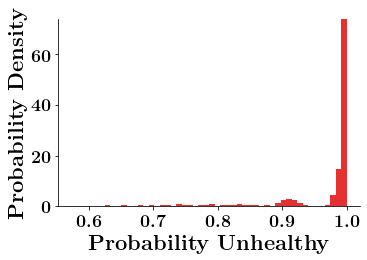

No handles with labels found to put in legend.


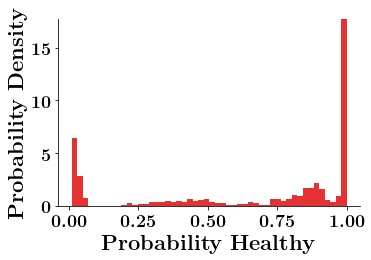

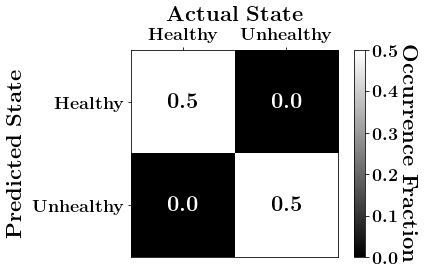

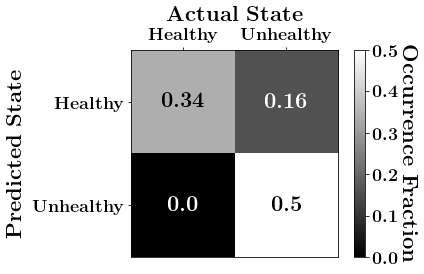

(1.0, 1.0, 1.0)
(0.8787878787878788, 1.0, 0.7575757575757576)


In [16]:
genplt.plot_histogram(model.predict(X_valid_unhealthy[...,np.newaxis])[:,1],[''],
               'Probability Unhealthy',
               'Probability Density',
               'cnn_mlp_predict_unhealthy',
               template='publication',
               legend_loc='upper right',
               nbins=50,
               ymax=0.0,
               num_col=1)

genplt.plot_histogram(model.predict(X_valid_healthy[...,np.newaxis])[:,0],[''],
               'Probability Healthy',
               'Probability Density',
               'cnn_mlp_predict_healthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               nbins=50,
               num_col=1)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_cnn_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'cnn_mlp_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_cnn_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'cnn_mlp_confmatrix_valid'
                       )
print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [22]:
import numpy as np

import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live

def create_mlp_classifier(
                   hidden_nodes,
                   input_shape,
                   classes,
                   ):
    
    mlp = Sequential()
    mlp.add(Input(shape=input_shape))
    mlp.add(Flatten())
    
    for i in range(len(hidden_nodes)):
        if i == 0:
            mlp.add(Dense(hidden_nodes[i], 
                              activation='selu'))
        else:
            mlp.add(Dense(hidden_nodes[i], activation='selu'))
            
    mlp.add(Dense(classes,activation='softmax'))
        
    return mlp

In [23]:

if not train:
# if os.path.isfile('../../Models/MLP-Classifier/Full/MLP.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('../../Models/MLP-Classifier/Full/MLP.h5')
    print(model.summary())
else:
    input_shape = [1024]
    dense_nodes = [512,128,64]

    # model,encoder,decoder = create_vae(param_dict)
    # model = create_classifier(param_dict)
    num_classes = 2

    model = create_mlp_classifier(dense_nodes,input_shape,num_classes)


    model.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy'])
    loss = model.fit(
                X_train,np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
#                 validation_split=0.2,
                validation_data=(X_valid,np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
                epochs=20,
                batch_size=8,
                verbose=1)

    model.save('../../Models/MLP-Classifier/Full/MLP.h5',save_format='tf')


    
Y_mlp_valid_pred = model.predict(X_valid)
Y_mlp_train_pred = model.predict(X_train)

Y_mlp_train_pred = np.argmax(Y_mlp_train_pred,axis=1)
Y_mlp_valid_pred = np.argmax(Y_mlp_valid_pred,axis=1)

Train on 1400 samples, validate on 1400 samples
Epoch 1/20
1400/1400 [==============================] - 1s 494us/sample - loss: 0.8480 - accuracy: 0.5207 - val_loss: 0.8258 - val_accuracy: 0.5000
Epoch 2/20
1400/1400 [==============================] - 0s 334us/sample - loss: 0.7162 - accuracy: 0.5621 - val_loss: 0.7075 - val_accuracy: 0.5000
Epoch 3/20
1400/1400 [==============================] - 0s 337us/sample - loss: 0.6495 - accuracy: 0.6400 - val_loss: 0.7341 - val_accuracy: 0.5779
Epoch 4/20
1400/1400 [==============================] - 0s 336us/sample - loss: 0.4959 - accuracy: 0.7693 - val_loss: 1.2066 - val_accuracy: 0.5264
Epoch 5/20
1400/1400 [==============================] - 0s 327us/sample - loss: 0.3363 - accuracy: 0.8600 - val_loss: 1.8928 - val_accuracy: 0.5357
Epoch 6/20
1400/1400 [==============================] - 0s 331us/sample - loss: 0.3892 - accuracy: 0.8329 - val_loss: 1.1072 - val_accuracy: 0.5936
Epoch 7/20
1400/1400 [==============================] - 0s 336us

In [24]:
model.predict(X_valid)

array([[2.3719278e-06, 9.9999762e-01],
       [9.7940814e-01, 2.0591874e-02],
       [4.7526433e-04, 9.9952471e-01],
       ...,
       [3.0014534e-03, 9.9699855e-01],
       [3.7176656e-03, 9.9628240e-01],
       [4.9224900e-06, 9.9999511e-01]], dtype=float32)

No handles with labels found to put in legend.


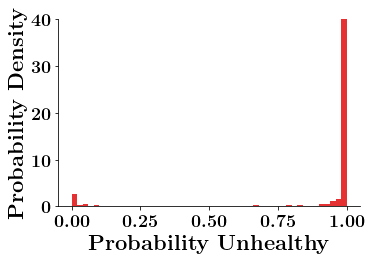

No handles with labels found to put in legend.


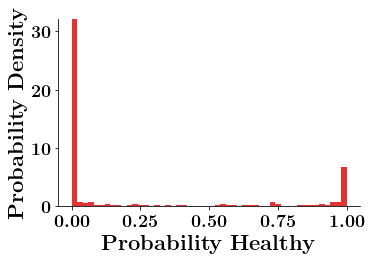

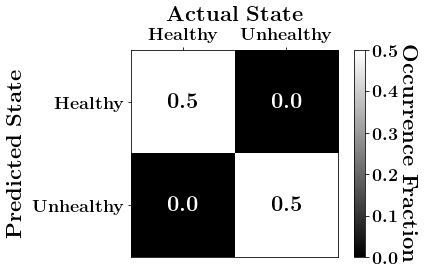

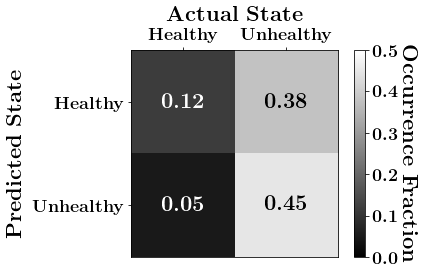

(1.0, 1.0, 1.0)
(0.6240255138199858, 0.7058823529411765, 0.5421686746987951)


In [25]:
genplt.plot_histogram(model.predict(X_valid_unhealthy)[:,1],[''],
               'Probability Unhealthy',
               'Probability Density',
               'mlp_predict_unhealthy',
               template='publication',
               legend_loc='upper right',
               nbins=50,
               ymax=0.0,
               num_col=1)

genplt.plot_histogram(model.predict(X_valid_healthy)[:,0],[''],
               'Probability Healthy',
               'Probability Density',
               'mlp_predict_healthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               nbins=50,
               num_col=1)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_mlp_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'mlp_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_mlp_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'mlp_confmatrix_valid'
                       )
print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [26]:

conf_matrix_mlp_valid = confusion_matrix(Y_valid, Y_mlp_valid_pred)
accuracy_mlp_valid = np.sum(np.diagonal(conf_matrix_mlp_valid)) / np.sum(conf_matrix_mlp_valid)
print(conf_matrix_mlp_valid)
print(accuracy_mlp_valid)

conf_matrix_mlp_train = confusion_matrix(Y_train, Y_mlp_train_pred)
accuracy_mlp_train = np.sum(np.diagonal(conf_matrix_mlp_train)) / np.sum(conf_matrix_mlp_train)
print(conf_matrix_mlp_train)
print(accuracy_mlp_train)

[[174 526]
 [ 69 631]]
0.575
[[693   7]
 [  1 699]]
0.9942857142857143


In [27]:

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='../../Models/MLP-Classifier/Lite/CNN-MLP.tflite')

def tflite_inference(data,tflite_interpreter):
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Test model on random input data.
    input_shape = input_details[0]['shape']
    # input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    input_data = data[:,np.newaxis,:,np.newaxis].astype(np.float32)

    output_shape = output_details[0]['shape']
    num_samples = input_data.shape[0]
    all_outputs = np.zeros((num_samples,output_shape[1]))

    for i in range(num_samples):

        interpreter.set_tensor(input_details[0]['index'], input_data[i,...])
        interpreter.invoke()

        # The function `get_tensor()` returns a copy of the tensor data.
        # Use `tensor()` in order to get a pointer to the tensor.
        output_data = interpreter.get_tensor(output_details[0]['index']).flatten()

        all_outputs[i,:] = output_data
        
    return all_outputs



In [247]:
Y_cnn_lite_train_pred = tflite_inference(X_train,interpreter)
Y_cnn_lite_valid_pred = tflite_inference(X_valid,interpreter)

Y_cnn_lite_train_pred = np.argmax(Y_cnn_lite_train_pred,axis=1)
Y_cnn_lite_valid_pred = np.argmax(Y_cnn_lite_valid_pred,axis=1)

In [248]:
conf_matrix_cnn_lite_valid = confusion_matrix(Y_valid, Y_cnn_lite_valid_pred)
accuracy_cnn_lite_valid = np.sum(np.diagonal(conf_matrix_cnn_lite_valid)) / np.sum(conf_matrix_cnn_lite_valid)
print(conf_matrix_cnn_lite_valid)
print(accuracy_cnn_lite_valid)

conf_matrix_cnn_lite_train = confusion_matrix(Y_train, Y_cnn_lite_train_pred)
accuracy_cnn_lite_train = np.sum(np.diagonal(conf_matrix_cnn_lite_train)) / np.sum(conf_matrix_cnn_lite_train)
print(conf_matrix_cnn_lite_train)
print(accuracy_cnn_lite_train)

[[419 281]
 [ 13 687]]
0.79
[[700   0]
 [  0 700]]
1.0


No handles with labels found to put in legend.


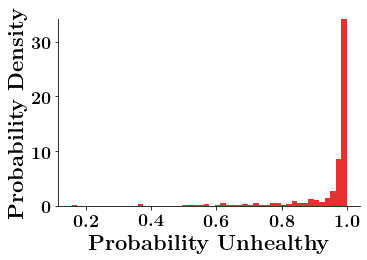

No handles with labels found to put in legend.


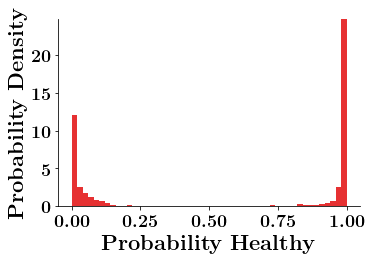

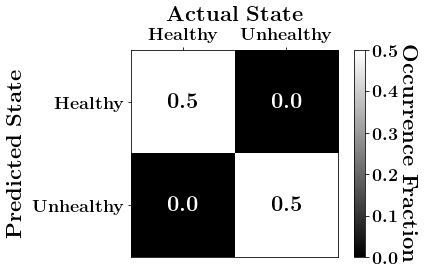

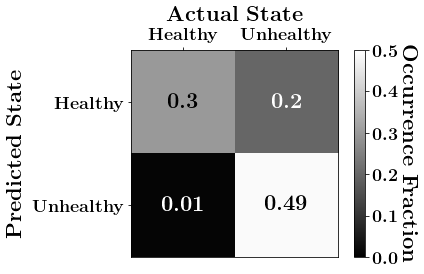

(1.0, 1.0, 1.0)
(0.8389434315100515, 0.9677419354838709, 0.7101449275362319)


In [249]:
genplt.plot_histogram(tflite_inference(X_valid_unhealthy,interpreter)[:,1],[''],
               'Probability Unhealthy',
               'Probability Density',
               'cnn_lite_predict_unhealthy',
               template='publication',
               legend_loc='upper right',
               nbins=50,
               ymax=0.0,
               num_col=1)

genplt.plot_histogram(tflite_inference(X_valid_healthy,interpreter)[:,0],[''],
               'Probability Healthy',
               'Probability Density',
               'cnn_lite_predict_healthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               nbins=50,
               num_col=1)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_cnn_lite_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'cnn_lite_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_cnn_lite_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'cnn_lite_confmatrix_valid'
                       )
print(balanced_train_accuracy)
print(balanced_valid_accuracy)